# Agent CFO — Performance Optimization & Design

---
This is the starter notebook for your project. Follow the required structure below.


You will design and optimize an Agent CFO assistant for a listed company. The assistant should answer finance/operations questions using RAG (Retrieval-Augmented Generation) + agentic reasoning, with response time (latency) as the primary metric.

Your system must:
*   Ingest the company’s public filings.
*   Retrieve relevant passages efficiently.
*   Compute ratios/trends via tool calls (calculator, table parsing).
*   Produce answers with valid citations to the correct page/table.


In [2]:
import os

# Best practice: do NOT hardcode API keys in notebook cells.
# If GEMINI_API_KEY is already set in the environment (e.g., via secrets), keep it.
# Otherwise, prompt the user to enter it securely (won't be echoed).
if os.environ.get("GEMINI_API_KEY"):
	print("GEMINI_API_KEY found in environment.")
else:
	try:
		from getpass import getpass
		key = getpass("Enter GEMINI_API_KEY (input hidden): ")
	except Exception:
		# Fallback to input() if getpass is unavailable in this environment
		key = input("Enter GEMINI_API_KEY: ")
	if key:
		os.environ["GEMINI_API_KEY"] = key
		print("GEMINI_API_KEY set for this session (not saved).")
	else:
		raise RuntimeError("GEMINI_API_KEY not provided. Set it via environment variables or re-run this cell.")

GEMINI_API_KEY found in environment.


## 1. Config & Secrets

Fill in your API keys in secrets. **Do not hardcode keys** in cells.

In [ ]:
import os

COMPANY_NAME = "DBS Bank"


## 2. Data Download (Dropbox)

*   Annual Reports: last 3–5 years.
*   Quarterly Results Packs & MD&A (Management Discussion & Analysis).
*   Investor Presentations and Press Releases.
*   These files must be submitted later as a deliverable in the Dropbox data pack.
*   Upload them under `/content/data/`.

Scope limit: each team will ingest minimally 15 PDF files total.


## 3. System Requirements

**Retrieval & RAG**
*   Use a vector index (e.g., FAISS, LlamaIndex) + a keyword filter (BM25/ElasticSearch).
*   Citations must include: report name, year, page number, section/table.

**Agentic Reasoning**
*   Support at least 3 tool types: calculator, table extraction, multi-document compare.
*   Reasoning must follow a plan-then-act pattern (not a single unstructured call).

**Instrumentation**
*   Log timings for: T_ingest, T_retrieve, T_rerank, T_reason, T_generate, T_total.
*   Log: tokens used, cache hits, tools invoked.
*   Record p50/p95 latencies.

 ### End-to-End PDF Extraction-Transform-Load & Vector Indexing Pipeline

In [1]:
# 1. Install the marker library
# This command should be run in your terminal or a Colab cell:
# !pip install marker-pdf -q

# 2. Import necessary components
import subprocess
import shutil
from pathlib import Path
import sys
import hashlib
import re
import cv2
import numpy as np
import pandas as pd


def md5sum(file_path: Path, chunk_size: int = 8192) -> str:
    """Return the hex md5 of a file."""
    h = hashlib.md5()
    with open(file_path, "rb") as f:
        for chunk in iter(lambda: f.read(chunk_size), b""):
            h.update(chunk)
    return h.hexdigest()

# === OCR & extraction helpers ===
NUM_PAT = re.compile(r"^[+-]?\d{1,4}(?:[.,]\d+)?%?$")
NIM_KEYWORDS = ["net interest margin", "nim"]

QUARTER_PAT = re.compile(r"\b([1-4Iil|])\s*[QO0]\s*([0-9O]{2,4})\b", re.IGNORECASE)
# Simpler decade-only pattern for quarters, e.g., 2Q24, 1Q25
QUARTER_SIMPLE_PAT = re.compile(r"\b([1-4])Q(2\d)\b", re.IGNORECASE)  # e.g., 2Q24, 1Q25

# --- OCR character normalization for quarter tokens (common OCR mistakes) ---
_CHAR_FIX = str.maketrans({
    "O":"0","o":"0",
    "S":"5","s":"5",
    "I":"1","l":"1","|":"1","!":"1",
    "D":"0",
    "B":"3","8":"3",
    "Z":"2","z":"2"
})
def normalize_token(t: str) -> str:
    t = (t or "").strip()
    return t.translate(_CHAR_FIX).replace(" ", "")

# --- Helper: detect quarter tokens from nearby Markdown file ---
def detect_qlabels_from_md(dest_dir: Path, image_name: str) -> list[str]:
    """
    Scan the figure's markdown file for quarter tokens (e.g., 2Q24, 1Q2025).
    Returns tokens in document order (deduped).
    """
    try:
        md_file = dest_dir / f"{dest_dir.name}.md"
        if not md_file.exists():
            cand = list(dest_dir.glob("*.md"))
            if not cand:
                return []
            md_file = cand[0]
        text = md_file.read_text(encoding="utf-8", errors="ignore")
    except Exception:
        return []
    # Collect all quarter tokens across the document
    tokens = []
    for m in QUARTER_PAT.finditer(text):
        q = f"{m.group(1)}Q{m.group(2)[-2:]}"
        tokens.append(q)
    # Deduplicate preserving order
    seen = set()
    ordered = []
    for q in tokens:
        if q not in seen:
            seen.add(q)
            ordered.append(q)
    return ordered

def load_image(path):
    p = Path(path)
    im = cv2.imread(str(p))
    if im is None:
        raise RuntimeError(f"cv2.imread() failed: {p}")
    return im

def preprocess(img_bgr):
    scale = 2.0
    img = cv2.resize(img_bgr, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.bilateralFilter(gray, d=7, sigmaColor=50, sigmaSpace=50)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)
    thr = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv2.THRESH_BINARY, 31, 8)
    return img, gray, thr, scale

def norm_num(s):
    s = s.replace(",", "").strip()
    pct = s.endswith("%")
    if pct:
        s = s[:-1]
    try:
        return float(s), pct
    except:
        return None, pct

def extract_numbers(ocr_results):
    rows = []
    for r in ocr_results or []:
        txt = str(r.get("text","")).strip()
        if NUM_PAT.match(txt):
            val, is_pct = norm_num(txt)
            if val is None:
                continue
            x1,y1,x2,y2 = r["bbox"]
            rows.append({
                "raw": txt, "value": val, "is_pct": is_pct, "conf": r.get("conf", None),
                "x1": int(x1), "y1": int(y1), "x2": int(x2), "y2": int(y2),
                "cx": int((x1+x2)/2), "cy": int((y1+y2)/2)
            })
    df = pd.DataFrame(rows).sort_values(["cy","cx"]).reset_index(drop=True)
    if "is_pct" not in df.columns and not df.empty:
        df["is_pct"] = df["raw"].astype(str).str.endswith("%")
    return df

def kmeans_1d(values, k=2, iters=20):
    values = np.asarray(values, dtype=float).reshape(-1,1)
    centers = np.array([values.min(), values.max()]).reshape(k,1)
    for _ in range(iters):
        d = ((values - centers.T)**2)
        labels = d.argmin(axis=1)
        new_centers = np.array([values[labels==i].mean() if np.any(labels==i) else centers[i] for i in range(k)]).reshape(k,1)
        if np.allclose(new_centers, centers, atol=1e-3):
            break
        centers = new_centers
    return labels, centers.flatten()

def run_easyocr(img_rgb):
    import easyocr
    global _EASY_OCR_READER
    try:
        _EASY_OCR_READER
    except NameError:
        _EASY_OCR_READER = None
    if _EASY_OCR_READER is None:
        _EASY_OCR_READER = easyocr.Reader(['en'], gpu=False, verbose=False)
    results = _EASY_OCR_READER.readtext(img_rgb, detail=1, paragraph=False)
    out = []
    for quad, text, conf in results:
        (x1,y1),(x2,y2),(x3,y3),(x4,y4) = quad
        out.append({"bbox": (int(x1),int(y1),int(x3),int(y3)), "text": str(text), "conf": float(conf)})
    return out

# --- Focused bottom-axis quarter detection using EasyOCR (robust to OCR confusions) ---
def detect_quarters_easyocr(img_bgr):
    """
    Use EasyOCR to read quarter labels along the bottom axis.
    Returns a list of (x_global, 'nQyy') sorted left→right, with half-year tokens removed.
    """
    H, W = img_bgr.shape[:2]
    y0 = int(H * 0.66)  # bottom ~34%
    crop = img_bgr[y0:H, 0:W]
    gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
    gray = cv2.bilateralFilter(gray, d=7, sigmaColor=50, sigmaSpace=50)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray = clahe.apply(gray)
    thr = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv2.THRESH_BINARY, 31, 8)
    # kernel = np.ones((3,3), np.uint8)
    # thr = cv2.morphologyEx(thr, cv2.MORPH_CLOSE, kernel, iterations=1)
    up = cv2.resize(thr, None, fx=3.0, fy=3.0, interpolation=cv2.INTER_CUBIC)
    img_rgb = cv2.cvtColor(up, cv2.COLOR_GRAY2RGB)
    ocr = run_easyocr(img_rgb)
    # PASS 1 — direct regex on normalized tokens
    tokens = []
    for r in ocr or []:
        raw = str(r.get("text","")).strip()
        x1,y1,x2,y2 = r["bbox"]
        cx_local = (x1 + x2) // 2
        cx_global = int(cx_local / 3.0)  # undo scaling
        tokens.append({"x": cx_global, "raw": raw, "norm": normalize_token(raw)})
    def _is_half_token(t: str) -> bool:
        t = (t or "").lower().replace(" ", "")
        return ("9m" in t) or ("1h" in t) or ("h1" in t) or ("h2" in t) or ("2h" in t)
    quarters = []
    for t in tokens:
        if _is_half_token(t["norm"]):
            continue
        m = QUARTER_PAT.search(t["norm"])
        if m:
            q = f"{m.group(1)}Q{m.group(2)[-2:]}"
            q = normalize_token(q)
            quarters.append((t["x"], q))
    # PASS 2 — stitch split tokens if too few quarters were found
    if len(quarters) < 4 and tokens:
        pieces = sorted(tokens, key=lambda d: d["x"])
        digits_1to4 = [p for p in pieces if p["norm"] in ("1","2","3","4")]
        q_only      = [p for p in pieces if p["norm"].upper() == "Q"]
        q_with_year = [p for p in pieces if re.fullmatch(r"Q[0-9O]{2,4}", p["norm"], flags=re.I)]
        years_2d    = [p for p in pieces if re.fullmatch(r"[0-9O]{2,4}", p["norm"])]
        def near(a, b, tol=70):
            return abs(a["x"] - b["x"]) <= tol
        for d in digits_1to4:
            # digit + Qyy
            candidates = [q for q in q_with_year if near(d, q)]
            if candidates:
                qtok = min(candidates, key=lambda q: abs(q["x"]-d["x"]))
                qyy = normalize_token(qtok["norm"])[1:]
                quarters.append(((d["x"]+qtok["x"])//2, f"{d['norm']}Q{qyy[-2:]}"))
                continue
            # digit + Q + yy
            qs = [q for q in q_only if near(d, q)]
            ys = [y for y in years_2d if near(d, y, tol=120)]
            if qs and ys:
                qtok = min(qs, key=lambda q: abs(q["x"]-d["x"]))
                ytok = min(ys, key=lambda y: abs(y["x"]-qtok["x"]))
                yy = normalize_token(ytok["norm"])
                quarters.append(((d["x"]+ytok["x"])//2, f"{d['norm']}Q{yy[-2:]}"))
                continue
    if not quarters:
        return []
    quarters.sort(key=lambda t: t[0])
    deduped, last_x = [], -10**9
    for x,q in quarters:
        if abs(x - last_x) <= 22:
            continue
        deduped.append((x,q))
        last_x = x
    return deduped

# NIM value band (pct) and geometry heuristics for verification
NIM_MIN, NIM_MAX = 1.3, 3.2
TOP_FRACTION = 0.65     # widen band: NIM labels often sit higher than 45%
RIGHT_HALF_ONLY = True  # NIM values appear on right panel in these deck

def is_strict_nim_image(img_path: Path) -> tuple[bool, str]:
    """
    Heuristic re-check:
      1) Title/text contains NIM keywords (coarse gate)
      2) Percent tokens mostly within NIM_MIN..NIM_MAX
      3) Tokens located in the top region (and right half, if enabled)
    Returns (ok, reason)
    """
    try:
        img_bgr = load_image(img_path)
        H, W = img_bgr.shape[:2]
        # 1) quick-text gate (soft): don't return yet; allow numeric signature to validate
        kw_ok = is_relevant_image(img_path, NIM_KEYWORDS)
        # 2) numeric gate on enhanced image
        img_up, gray, thr, scale = preprocess(img_bgr)
        img_rgb = cv2.cvtColor(thr, cv2.COLOR_GRAY2RGB)
        ocr = run_easyocr(img_rgb)
        # --- Semantic gate: accept classic NIM slides based on stable labels ---
        text_lower = " ".join(str(r.get("text", "")).lower() for r in ocr or [])
        has_nim = "net interest margin" in text_lower
        has_cb  = "commercial book" in text_lower
        has_grp = "group" in text_lower
        if has_nim and (has_cb or has_grp):
            which = [w for w, ok in (("nim", has_nim), ("cb", has_cb), ("grp", has_grp)) if ok]
            return (True, f"ok_semantic({'+' .join(which)})")
        df = extract_numbers(ocr)
        if df.empty:
            return (False, "no_numbers")
        # geometry filters (apply before value checks)
        top_cut = int(img_up.shape[0] * 0.62)
        cond_geom = (df["cy"] < top_cut)
        if RIGHT_HALF_ONLY:
            cond_geom &= (df["cx"] > (img_up.shape[1] // 2))

        # 2a) Preferred path: explicit percentage tokens
        df_pct = df[(df["is_pct"] == True) & cond_geom].copy()
        if not df_pct.empty:
            in_band = df_pct["value"].between(NIM_MIN, NIM_MAX)
            ratio = float(in_band.sum()) / float(len(df_pct))
            if ratio >= 0.6:
                return (True, "ok")
            else:
                return (False, f"non_nim_values_out_of_band({ratio:.2f})")

        # 2b) Fallback: some decks omit the % sign near the series values.
        # Accept plain numbers in the NIM range if units are explicit or implied, or if numeric signature is strong.
        title_text = text_lower  # already computed above
        has_units_pct = "(%)" in title_text or "margin (%)" in title_text or has_nim
        df_nums = df[(df["is_pct"] == False) & cond_geom].copy()
        if not df_nums.empty:
            in_band = df_nums["value"].between(NIM_MIN, NIM_MAX)
            ratio = float(in_band.sum()) / float(len(df_nums))
            # Case A: explicit or implied units in title → accept when enough in-band hits
            if has_units_pct and ratio >= 0.6 and in_band.sum() >= 3:
                return (True, "ok_no_percent_signs")
            # Case B: title OCR may have missed units; if the quick keyword gate succeeded, accept with a stricter ratio
            if kw_ok and ratio >= 0.7 and in_band.sum() >= 3:
                return (True, "ok_numeric_signature")
            # Case C: strong structural evidence (quarters on bottom) + numeric signature in band
            q_xy_fallback = detect_quarters_easyocr(img_bgr)
            if len(q_xy_fallback) >= 4 and ratio >= 0.6 and in_band.sum() >= 3:
                return (True, "ok_structural_numeric_signature")

        # Final decision: if numeric signature still failed, report clearer reason
        if not kw_ok:
            return (False, "irrelevant_non_nim")
        else:
            return (False, "no_percentages_or_units")
    except Exception as e:
        return (False, f"exception:{e}")


# --- Helper: detect and order quarter labels from OCR ---
def detect_qlabels(ocr_results, img_width: int) -> list[str]:
    """
    Extract quarter tokens like 1Q25, 2Q2025 from OCR and return them left→right.
    We keep only tokens on the right half (where the series values live in your layout).
    """
    qtokens = []
    mid_x = img_width // 2
    for r in ocr_results or []:
        txt = str(r.get("text","")).strip()
        m = QUARTER_PAT.search(txt)
        if not m:
            continue
        x1,y1,x2,y2 = r["bbox"]
        cx = (x1 + x2) // 2
        if cx <= mid_x:
            continue  # ignore left panel quarters/titles
        q = f"{m.group(1)}Q{m.group(2)[-2:]}"  # normalize to 1Q25 style
        qtokens.append((cx, q))
    # sort by visual x-position and deduplicate by both text and proximity (ignore near-duplicates)
    qtokens.sort(key=lambda x: x[0])
    # Deduplicate by both text and proximity (ignore near-duplicates)
    ordered = []
    last_x = -9999
    last_q = None
    for x, q in qtokens:
        if last_q == q and abs(x - last_x) < 30:
            continue
        ordered.append(q)
        last_x, last_q = x, q
    return ordered

# === Focused bottom-of-chart scan for small quarter labels ===
def detect_qlabels_bottom(img_bgr) -> list[str]:
    """
    Focused pass: crop the bottom ~30% (where quarter labels usually sit),
    enhance contrast, OCR, and extract quarter tokens left→right.
    """
    try:
        H, W = img_bgr.shape[:2]
        y0 = int(H * 0.60)  # bottom 40%
        crop = img_bgr[y0:H, 0:W]
        # Enhance: grayscale -> bilateral -> CLAHE -> adaptive threshold
        gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
        gray = cv2.bilateralFilter(gray, d=7, sigmaColor=50, sigmaSpace=50)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        gray = clahe.apply(gray)
        thr = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                    cv2.THRESH_BINARY, 31, 8)
        # Morphological close to strengthen thin glyphs
        kernel = np.ones((3,3), np.uint8)
        thr = cv2.morphologyEx(thr, cv2.MORPH_CLOSE, kernel, iterations=1)
        # Upscale for small text
        up = cv2.resize(thr, None, fx=2.5, fy=2.5, interpolation=cv2.INTER_CUBIC)
        img_rgb = cv2.cvtColor(up, cv2.COLOR_GRAY2RGB)
        ocr = run_easyocr(img_rgb)
        # Map bboxes back to global coords: decide single-panel vs split-panel
        mid_x = W // 2
        left_quarters, right_quarters = [], []
        left_tokens_text, right_tokens_text = [], []
        for r in ocr or []:
            raw = str(r.get("text", "")).strip()
            x1,y1,x2,y2 = r["bbox"]
            cx_local = (x1 + x2) // 2
            cx_global = int(cx_local / 2.5)  # undo scale

            if cx_global <= mid_x:
                left_tokens_text.append(raw.lower())
            else:
                right_tokens_text.append(raw.lower())

            m = QUARTER_PAT.search(raw)
            if not m:
                continue
            q = f"{m.group(1)}Q{m.group(2)[-2:]}"
            if cx_global <= mid_x:
                left_quarters.append((cx_global, q))
            else:
                right_quarters.append((cx_global, q))

        def has_halfyear_or_9m(tokens: list[str]) -> bool:
            s = " ".join(tokens)
            return ("9m" in s) or ("1h" in s) or ("h1" in s) or ("h2" in s) or ("2h" in s)

        left_has_h = has_halfyear_or_9m(left_tokens_text)
        # Panel selection logic: prefer both halves unless left clearly half-year and right has ≥3 quarters
        if (not left_has_h) and (len(left_quarters) + len(right_quarters) >= 2):
            # Likely single panel or weak OCR on one side → use both halves
            qtokens = left_quarters + right_quarters
        elif len(right_quarters) >= 3:
            # Strong right panel signal → use right only
            qtokens = right_quarters
        else:
            # Fallback: use everything we found
            qtokens = left_quarters + right_quarters

        # Sort and dedupe close neighbors (≤18 px)
        qtokens.sort(key=lambda t: t[0])
        deduped = []
        last_x = -10**9
        for x, q in qtokens:
            if abs(x - last_x) <= 18:
                continue
            deduped.append((x, q))
            last_x = x

        return [q for _, q in deduped]
    except Exception:
        return []

# --- Same as detect_qlabels_bottom, but returns (x, label) for alignment ---
def detect_qlabels_bottom_with_xy(img_bgr) -> list[tuple[int, str]]:
    try:
        H, W = img_bgr.shape[:2]
        y0 = int(H * 0.60)
        crop = img_bgr[y0:H, 0:W]
        gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
        gray = cv2.bilateralFilter(gray, d=7, sigmaColor=50, sigmaSpace=50)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        gray = clahe.apply(gray)
        thr = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                    cv2.THRESH_BINARY, 31, 8)
        kernel = np.ones((3,3), np.uint8)
        thr = cv2.morphologyEx(thr, cv2.MORPH_CLOSE, kernel, iterations=1)
        up = cv2.resize(thr, None, fx=2.5, fy=2.5, interpolation=cv2.INTER_CUBIC)
        img_rgb = cv2.cvtColor(up, cv2.COLOR_GRAY2RGB)
        ocr = run_easyocr(img_rgb)

        mid_x = W // 2
        left_quarters, right_quarters = [], []
        left_tokens_text = []
        for r in ocr or []:
            raw = str(r.get("text", "")).strip()
            x1,y1,x2,y2 = r["bbox"]
            cx_local = (x1 + x2) // 2
            cx_global = int(cx_local / 2.5)
            if cx_global <= mid_x:
                left_tokens_text.append(raw.lower())
            m = QUARTER_PAT.search(raw)
            if not m:
                continue
            q = f"{m.group(1)}Q{m.group(2)[-2:]}"
            if cx_global <= mid_x:
                left_quarters.append((cx_global, q))
            else:
                right_quarters.append((cx_global, q))

        def has_halfyear_or_9m(tokens: list[str]) -> bool:
            s = " ".join(tokens)
            return ("9m" in s) or ("1h" in s) or ("h1" in s) or ("h2" in s) or ("2h" in s)

        left_has_h = has_halfyear_or_9m(left_tokens_text)
        if (not left_has_h) and (len(left_quarters) + len(right_quarters) >= 2):
            # Likely single panel or weak OCR on one side → use both halves
            qtokens = left_quarters + right_quarters
        elif len(right_quarters) >= 3:
            # Strong right panel signal → use right only
            qtokens = right_quarters
        else:
            # Fallback: use everything we found
            qtokens = left_quarters + right_quarters

        qtokens.sort(key=lambda t: t[0])
        deduped = []
        last_x = -10**9
        for x, q in qtokens:
            if abs(x - last_x) <= 18:
                continue
            deduped.append((x, q))
            last_x = x
        return deduped
    except Exception:
        return []

# --- Merge two ordered quarter lists ---
def _merge_ordered(primary: list[str], secondary: list[str]) -> list[str]:
    """
    Merge two left→right sequences, keeping 'primary' order and filling with
    any unseen items from 'secondary' in their order.
    """
    out = list(primary)
    seen = set(primary)
    for q in secondary:
        if q not in seen:
            out.append(q)
            seen.add(q)
    return out

# --- Expand a quarter label like '2Q24' forward n quarters ---
def _expand_quarters(start_q: str, n: int) -> list[str]:
    """
    Given a label like '2Q24', produce a forward sequence of n quarters:
    2Q24, 3Q24, 4Q24, 1Q25, 2Q25, ...
    """
    m = QUARTER_PAT.match(start_q) or QUARTER_SIMPLE_PAT.match(start_q)
    if not m:
        return []
    q = int(m.group(1))
    yy = int(m.group(2)[-2:])
    seq = []
    for _ in range(n):
        seq.append(f"{q}Q{yy:02d}")
        q += 1
        if q == 5:
            q = 1
            yy = (yy + 1) % 100
    return seq

# --- Find a plausible anchor quarter like 2Q24 from OCR or markdown tokens ---
def _anchor_quarter_from_texts(ocr_results, md_tokens: list[str]) -> str | None:
    """
    Find any token like 1Q2x..4Q2x from OCR texts or markdown tokens.
    Returns the first plausible anchor (normalized to e.g. 2Q24) or None.
    """
    # prefer bottom/ocr-derived tokens first (already parsed in detect_qlabels_bottom)
    # fallback: scan all OCR texts with simple pattern
    for r in ocr_results or []:
        txt = str(r.get("text","")).strip()
        m = QUARTER_SIMPLE_PAT.search(txt)
        if m:
            return f"{m.group(1)}Q{m.group(2)}"
    # fallback to any markdown token that matches the decade pattern
    for t in md_tokens or []:
        m = QUARTER_SIMPLE_PAT.match(t)
        if m:
            return f"{m.group(1)}Q{m.group(2)}"
    return None

def extract_series_from_df(df, img_up, ocr_results=None, qlabels_hint=None):
    H, W = img_up.shape[:2]
    mid_x = W//2
    top_band_min = int(H * 0.38)
    top_band_max = int(H * 0.58)

    # Detect bottom quarter labels (with x) early to infer layout
    detected_q_bot_xy = detect_quarters_easyocr(img_up)
    left_count  = sum(1 for x, _ in detected_q_bot_xy if x <= mid_x)
    right_count = sum(1 for x, _ in detected_q_bot_xy if x >  mid_x)
    # Heuristic: if we see ≥4 quarter tokens spanning both halves, it's a single-panel timeline
    single_panel = (len(detected_q_bot_xy) >= 4 and left_count >= 1 and right_count >= 1)

    # Filter tokens: keep right-half only for split panels; keep all for single panels
    if single_panel:
        pct = df[(df.is_pct==True)].copy()
        nums = df[(df.is_pct==False)].copy()
    else:
        pct = df[(df.is_pct==True) & (df.cx > mid_x)].copy()
        nums = df[(df.is_pct==False) & (df.cx > mid_x)].copy()

    if pct.empty:
        # Fallback for charts that omit the '%' sign on the value dots.
        # Use a wider top band and avoid forcing right-half on single-panel timelines.
        approx_top = int(H * 0.60)
        if single_panel:
            cx_mask = (df.cx > 0)  # keep all x for single panel
        else:
            cx_mask = (df.cx > mid_x)
        cand_pct = df[cx_mask & df.value.between(NIM_MIN, NIM_MAX) & (df.cy < approx_top)].copy()
        if not cand_pct.empty:
            cand_pct["is_pct"] = True
            pct = cand_pct

    nim_df = pd.DataFrame()
    if not pct.empty:
        # Try to split into two horizontal series by Y even when we have only 3 quarters (→ 6 points)
        # Deduplicate by proximity on Y to stabilize clustering
        y_sorted = pct.sort_values("cy")["cy"].to_numpy()
        uniq_y = []
        last_y = -10**9
        for yy in y_sorted:
            if abs(yy - last_y) >= 6:  # 6px tolerance for duplicates
                uniq_y.append(yy)
                last_y = yy
        # Attempt k-means when we have at least 4 points total (≈ 2 series × 2 quarters)
        if pct.shape[0] >= 4 and len(uniq_y) >= 2:
            labels, centers = kmeans_1d(pct["cy"].values, k=2)
            pct["series"] = labels
            order = np.argsort(centers)  # top (commercial) should have smaller y
            remap = {order[0]: "Commercial NIM (%)", order[1]: "Group NIM (%)"}
            pct["series_name"] = pct["series"].map(remap)
            # Sanity: ensure both series have data; else collapse to one
            counts = pct["series_name"].value_counts()
            if any(counts.get(name, 0) == 0 for name in ["Commercial NIM (%)", "Group NIM (%)"]):
                pct["series_name"] = "NIM (%)"
        else:
            pct["series_name"] = "NIM (%)"

        # Reuse bottom-quarter labels captured above
        detected_q_bot = [q for _, q in detected_q_bot_xy]
        detected_q_ocr = detect_qlabels(ocr_results or [], W) if ocr_results is not None else []
        if len(detected_q_bot) > len(detected_q_ocr):
            detected_q = _merge_ordered(detected_q_bot, detected_q_ocr)
        else:
            detected_q = _merge_ordered(detected_q_ocr, detected_q_bot)
        rows = []
        for name, sub in pct.groupby("series_name"):
            # Sort left→right and collapse near-duplicates (same x within 12px)
            sub_sorted = sub.sort_values("cx")
            uniq_rows = []
            last_x = -10**9
            for r in sub_sorted.itertuples(index=False):
                if abs(r.cx - last_x) < 12:
                    continue
                uniq_rows.append(r)
                last_x = r.cx
            # Keep only the right-panel portion (already ensured by cx>mid_x earlier)
            pick = list(uniq_rows)[-5:]  # cap to 5 most recent positions, but may be <5
            n = len(pick)
            if n == 0:
                continue
            labels = []
            # Robust mapping: map each value x to its nearest bottom quarter label x (right panel).
            # Filter any accidental half-year tokens (1H/2H/H1/H2/9M) just in case OCR returns them.
            def _is_half_token(t: str) -> bool:
                t = (t or "").lower().replace(" ", "")
                return ("9m" in t) or ("1h" in t) or ("h1" in t) or ("h2" in t) or ("2h" in t) or ("h24" in t) or ("h23" in t)

            # detected_q_bot_xy already respects split vs single panel. Keep right-panel positions only here.
            q_xy = []
            for x, q in detected_q_bot_xy:
                if x <= mid_x:
                    continue
                if _is_half_token(q):
                    continue
                q_xy.append((x, q))

            if len(q_xy) < n:
                # Borrow from left panel if they look like quarters (and not half-year)
                for x, q in detected_q_bot_xy:
                    if x > mid_x:
                        continue
                    if _is_half_token(q):
                        continue
                    q_xy.append((x, q))

            if q_xy:
                q_xy.sort(key=lambda t: t[0])  # left→right
                # Map each picked value to nearest quarter label by x-position
                vx = [rr.cx for rr in pick]
                qx = [x for x, _ in q_xy]
                ql = [q for _, q in q_xy]
                mapped = []
                for x in vx:
                    j = int(np.argmin([abs(x - xx) for xx in qx])) if qx else -1
                    mapped.append(ql[j] if j >= 0 else None)
                labels = mapped
            else:
                detected_q_ocr = detect_qlabels(ocr_results or [], W) if ocr_results is not None else []
                if detected_q_ocr:
                    labels = detected_q_ocr[-n:] if len(detected_q_ocr) >= n else detected_q_ocr

            # If still short, use markdown tokens; else expand from an anchor like 2Q24
            if (not labels) or (len(labels) != n):
                if qlabels_hint:
                    labels = qlabels_hint[-n:] if len(qlabels_hint) >= n else qlabels_hint
            if (not labels) or (len(labels) != n):
                anchor = _anchor_quarter_from_texts(ocr_results, qlabels_hint)
                if anchor:
                    labels = _expand_quarters(anchor, n)
            if (not labels) or (len(labels) != n):
                labels = [f"{i+1}Q??" for i in range(n)]
            # Ensure left→right order for consistent mapping to labels
            pick = sorted(pick, key=lambda r: r.cx)
            labels = list(labels)[:n]
            for i, r in enumerate(pick):
                if i >= len(labels):
                    break
                rows.append({"Quarter": labels[i], "series": name, "value": r.value})
        if rows:
            nim_table = pd.DataFrame(rows)
            # Guard: drop rows with missing labels
            nim_table = nim_table.dropna(subset=["Quarter", "series"])  
            # If multiple detections map to the same (Quarter, series), average them
            if not nim_table.empty:
                dupe_mask = nim_table.duplicated(subset=["Quarter", "series"], keep=False)
                if dupe_mask.any():
                    # Aggregate duplicates by mean (stable for minor OCR jitter)
                    nim_table = nim_table.groupby(["Quarter", "series"], as_index=False)["value"].mean()
            nim_df = nim_table.pivot(index="Quarter", columns="series", values="value").reset_index()

    # NIM-only mode: skip NII extraction entirely
    nii_df = pd.DataFrame()

    def _sort_q(df_in):
        if df_in is None or df_in.empty or "Quarter" not in df_in.columns:
            return df_in
        # Try to sort by numeric (Q#, year) if labels are like 2Q24; else keep input order
        def _key(q):
            m = QUARTER_PAT.match(str(q))
            if not m:
                return (999, 999)
            qn = int(m.group(1))
            yr = int(m.group(2)[-2:])  # last two digits
            return (yr, qn)
        try:
            return df_in.assign(_k=df_in["Quarter"].map(_key)).sort_values("_k").drop(columns=["_k"]).reset_index(drop=True)
        except Exception:
            return df_in.reset_index(drop=True)

    return _sort_q(nim_df), _sort_q(nii_df)

def _extract_md_context(dest_dir: Path, image_name: str) -> dict:
    """
    Best-effort: read the <pdf_stem>.md in dest_dir, find the <image_name> reference,
    capture nearby headings and a neighbor paragraph to build context.
    """
    try:
        # Prefer "<pdf_stem>.md", else any .md
        md_file = dest_dir / f"{dest_dir.name}.md"
        if not md_file.exists():
            cands = list(dest_dir.glob("*.md"))
            if not cands:
                return {}
            md_file = cands[0]
        lines = md_file.read_text(encoding="utf-8", errors="ignore").splitlines()
    except Exception:
        return {}

    # Find the image line
    idx = None
    for i, line in enumerate(lines):
        if image_name in line:
            idx = i
            break
    if idx is None:
        return {}

    # Walk upward to find up to two headings and a neighbor paragraph
    figure_title = None
    section_title = None
    neighbor_text = None

    # Find the closest preceding heading(s)
    for j in range(idx - 1, -1, -1):
        s = lines[j].strip()
        if not s:
            continue
        # markdown heading levels
        if s.startswith("#"):
            # Remove leading #'s and whitespace
            heading = s.lstrip("#").strip()
            if figure_title is None:
                figure_title = heading
            elif section_title is None:
                section_title = heading
                break

    # Find a non-empty paragraph between the image and last heading
    for j in range(idx - 1, -1, -1):
        s = lines[j].strip()
        if s and not s.startswith("#") and not s.startswith("![]("):
            neighbor_text = s
            break

    out = {}
    if figure_title: out["figure_title"] = figure_title
    if section_title: out["section_title"] = section_title
    if neighbor_text: out["neighbor_text"] = neighbor_text
    return out

def _parse_page_and_figure_from_name(image_name: str) -> dict:
    """
    Extract page/figure indices from names like '_page_0_Figure_2.jpeg'.
    """
    info = {}
    try:
        # Very loose parse
        if "_page_" in image_name:
            after = image_name.split("_page_", 1)[1]
            num = after.split("_", 1)[0]
            info["page"] = int(num) + 1  # 1-based for human readability
        if "Figure_" in image_name:
            after = image_name.split("Figure_", 1)[1]
            num = ""
            for ch in after:
                if ch.isdigit():
                    num += ch
                else:
                    break
            if num:
                info["figure_index"] = int(num)
    except Exception:
        pass
    return info

def is_relevant_image(img_path, keywords):
    """Robust relevance check for NIM slides.
    - Reuse the singleton EasyOCR reader (run_easyocr)
    - Accept split tokens like "Net" / "interest" / "margin" (not only the exact phrase)
    - Fallback: if we see ≥4 quarter labels on the bottom AND ≥3 top-band percent-like values in NIM range, treat as relevant.
    """
    try:
        img = cv2.imread(str(img_path))
        if img is None:
            return False

        # Pass A: OCR on lightly upscaled original
        view_a = cv2.resize(img, None, fx=1.3, fy=1.3, interpolation=cv2.INTER_CUBIC)
        ocr_a = run_easyocr(cv2.cvtColor(view_a, cv2.COLOR_BGR2RGB))
        tokens_a = [str(r.get("text","")).lower() for r in (ocr_a or [])]
        text_a = " ".join(tokens_a)

        # Quick phrase match (exact keywords like "net interest margin")
        if any(k in text_a for k in keywords):
            return True

        # Pass B: OCR on preprocessed thresholded view (more stable for thin fonts)
        _, _, thr, _ = preprocess(img)
        ocr_b = run_easyocr(cv2.cvtColor(thr, cv2.COLOR_GRAY2RGB))
        tokens_b = [str(r.get("text","")).lower() for r in (ocr_b or [])]
        text_b = " ".join(tokens_b)
        if any(k in text_b for k in keywords):
            return True

        # Token-level split-word check
        tokens = tokens_a + tokens_b
        has_net      = any("net" in t for t in tokens)
        has_interest = any("interest" in t for t in tokens)
        has_margin   = any("margin" in t for t in tokens or [])
        has_nim_abbr = any(re.search(r"\bnim\b", t) for t in tokens)
        has_cb       = any("commercial book" in t for t in tokens)
        has_grp      = any(re.search(r"\bgroup\b", t) for t in tokens)
        if (has_net and has_interest and has_margin) or has_nim_abbr:
            # Strengthen with context words if available
            if has_cb or has_grp:
                return True

        # Structural fallback: quarters + percent values in the NIM band
        q_xy = detect_quarters_easyocr(img)
        if len(q_xy) >= 4:
            # Look for ≥3 percent-ish values in the top band within NIM_MIN..NIM_MAX
            df = extract_numbers(ocr_b)
            if not df.empty:
                H, W = view_a.shape[:2]
                top_cut = int(H * 0.55)
                in_top = df["cy"] < top_cut
                in_band = df["value"].between(NIM_MIN, NIM_MAX)
                pctish = in_band  # allow numbers without % (the series sometimes omit it)
                if int((in_top & pctish).sum()) >= 3:
                    return True

        return False
    except Exception:
        return False


# =============== Pluggable OCR Extractor Framework ===============
class BaseChartExtractor:
    """
    Minimal interface for pluggable chart extractors.
    Implement `is_relevant` and `extract_table`, then call `handle_image(...)`.
    """
    name = "base"
    topic = "Generic Chart"
    units = None
    entity = None
    keywords = []

    def is_relevant(self, img_path: Path) -> bool:
        return is_relevant_image(img_path, self.keywords)

    def extract_table(self, img_path: Path, dest_dir: Path, pdf_name: str):
        """
        Return (df, context_dict) or (None, reason) on failure.
        context_dict will be merged into the _context object.
        """
        raise NotImplementedError

    def _build_context(self, pdf_name: str, img_path: Path, dest_dir: Path, extra: dict | None = None) -> dict:
        ctx = {
            "source_pdf": pdf_name,
            "image": img_path.name,
            "topic": self.topic,
        }
        if self.units:  ctx["units"]  = self.units
        if self.entity: ctx["entity"] = self.entity
        ctx.update(_parse_page_and_figure_from_name(img_path.name))
        md_ctx = _extract_md_context(dest_dir, img_path.name)
        if md_ctx: ctx.update(md_ctx)
        if extra:  ctx.update(extra)
        return ctx

    def _write_jsonl(self, out_path: Path, ctx: dict, df: pd.DataFrame):
        import json
        with open(out_path, "w", encoding="utf-8") as f:
            f.write(json.dumps({"_context": ctx}, ensure_ascii=False) + "\n")
            for rec in df.to_dict(orient="records"):
                rec_out = dict(rec)
                rec_out["_meta"] = {"source_pdf": ctx.get("source_pdf"), "image": ctx.get("image")}
                f.write(json.dumps(rec_out, ensure_ascii=False) + "\n")

    def handle_image(self, img_path: Path, dest_dir: Path, pdf_name: str, *, bypass_relevance: bool = False):
        if not bypass_relevance and not self.is_relevant(img_path):
            return False, "Not relevant"
        df, ctx_extra = self.extract_table(img_path, dest_dir, pdf_name)
        if df is None or df.empty:
            return False, ctx_extra if isinstance(ctx_extra, str) else "No data"
        # Build context and summary if possible
        ctx = self._build_context(pdf_name, img_path, dest_dir, extra=ctx_extra if isinstance(ctx_extra, dict) else {})
        try:
            cols = [c for c in df.columns if c != "Quarter"]
            if len(df) >= 2 and cols:
                def _pick_q(s):
                    return s if QUARTER_PAT.match(str(s) or "") else None
                _fq = str(df.iloc[0]["Quarter"])
                _lq = str(df.iloc[-1]["Quarter"])
                first_q = _pick_q(_fq) or (_fq if "??" not in _fq else "start")
                last_q  = _pick_q(_lq) or (_lq if "??" not in _lq else "end")
                pieces = []
                for col in cols[:2]:
                    a = df.iloc[0][col]
                    b = df.iloc[-1][col]
                    if pd.notna(a) and pd.notna(b):
                        suffix = "%" if "NIM" in col or ctx.get("units") == "percent" else ""
                        pieces.append(f"{col}: {a:.2f}{suffix} → {b:.2f}{suffix}")
                if pieces:
                    ctx["summary"] = f"Figure shows {', '.join(pieces)} from {first_q} to {last_q}."
        except Exception:
            pass
        out_path = img_path.with_suffix(f".{self.name}.jsonl")
        self._write_jsonl(out_path, ctx, df)
        return True, str(out_path)

class NIMExtractor(BaseChartExtractor):
    name = "nim"
    topic = "Net Interest Margin"
    units = "percent"
    entity = "DBS"
    keywords = NIM_KEYWORDS

    def extract_table(self, img_path: Path, dest_dir: Path, pdf_name: str):
        # Reuse the existing pipeline
        img_bgr = load_image(img_path)
        img_up, gray, thr, scale = preprocess(img_bgr)
        img_rgb = cv2.cvtColor(thr, cv2.COLOR_GRAY2RGB)
        ocr = run_easyocr(img_rgb)
        df_tokens = extract_numbers(ocr)
        if df_tokens.empty:
            return None, "No numeric tokens detected"
        md_q = detect_qlabels_from_md(dest_dir, img_path.name)
        nim_df, _nii_df = extract_series_from_df(df_tokens, img_up, ocr_results=ocr, qlabels_hint=md_q)
        if nim_df is None or nim_df.empty:
            return None, "No NIM table detected"
        return nim_df, {"topic": self.topic, "units": self.units, "entity": self.entity}

# Registry of extractors (add more later)
EXTRACTORS: list[BaseChartExtractor] = [
    NIMExtractor(),
]
# ============= End pluggable extractor framework =============

# === Single-image rebuild/verify mode (optional) ===
# Set single_image_mode=True and point single_image_path to a specific extracted image
# to run the two-stage gate + extraction just for that file, then exit.
single_image_mode = False
single_image_paths: list[Path] = [
   
]
# Optional singular fallback path (legacy): set to a string/Path if you want a single-image override
single_image_path = None

# Legacy fallback (ignored i
 # Toggle: if True → normal md5 skip; if False → always reprocess
md5_check = True

# 3. Define the path to the directory containing your PDF files
# pdf_directory = Path("/Users/marcusfoo/Documents/GitHub/PTO_ICT3113_Grp1/All/")
pdf_directory = Path("./All/")
# === Fast path: single image only ===
# === Fast path: single/multi-image only ===
if single_image_mode:
    paths: list[Path] = []
    if single_image_paths:
        paths = [Path(p) for p in single_image_paths if p is not None]
    elif single_image_path:
        paths = [Path(single_image_path)]

    if not paths:
        print("❌ single_image_mode=True but no paths were provided.")
        sys.exit(1)

    print("--- Multi-image mode ---")
    successes = 0
    for img_path in paths:
        if not img_path.exists():
            print(f"❌ Missing: {img_path}")
            continue

        dest_dir = img_path.parent
        pdf_name = f"{dest_dir.name}.pdf"
        print(f"\n🖼️  Image: {img_path.name}  |  PDF: {pdf_name}")

        # Quick quarter readout (EasyOCR-only, bottom axis)
        try:
            img_bgr_quarters = load_image(img_path)
            q_xy = detect_quarters_easyocr(img_bgr_quarters)
            if q_xy:
                print("   📎 Quarters (EasyOCR):", ", ".join([q for _,q in q_xy]))
            else:
                print("   📎 Quarters (EasyOCR): <none>")
        except Exception as _qe:
            print(f"   📎 Quarters (EasyOCR): error → {_qe}")

        any_hit = False

        for ex in EXTRACTORS:
            print(f"   · [{ex.name}] quick gate…", end=" ")
            if not ex.is_relevant(img_path):
                print("⏭️  Not relevant")
                continue
            print("✅ ok; strict gate…", end=" ")
            ok_strict, reason = is_strict_nim_image(img_path)
            if not ok_strict:
                print(f"⏭️  Failed strict ({reason})")
                continue
            print("✅ Strict OK — extracting…")

            # Extract directly so we can print the table; still write JSONL
            df, ctx_extra = ex.extract_table(img_path, dest_dir, pdf_name)
            if df is None or df.empty:
                print("   ⚠️ No data extracted.")
                continue

            any_hit = True
            successes += 1

            # Build context + summary and write JSONL
            ctx = ex._build_context(pdf_name, img_path, dest_dir, extra=ctx_extra if isinstance(ctx_extra, dict) else {})
            try:
                cols = [c for c in df.columns if c != "Quarter"]
                if len(df) >= 2 and cols:
                    def _pick_q(s):
                        return s if QUARTER_PAT.match(str(s) or "") else None
                    _fq = str(df.iloc[0]["Quarter"]); _lq = str(df.iloc[-1]["Quarter"])
                    first_q = _pick_q(_fq) or (_fq if "??" not in _fq else "start")
                    last_q  = _pick_q(_lq) or (_lq if "??" not in _lq else "end")
                    pieces = []
                    for col in cols[:2]:
                        a = df.iloc[0][col]; b = df.iloc[-1][col]
                        if pd.notna(a) and pd.notna(b):
                            suffix = "%" if "NIM" in col or ctx.get("units") == "percent" else ""
                            pieces.append(f"{col}: {a:.2f}{suffix} → {b:.2f}{suffix}")
                    if pieces:
                        ctx["summary"] = f"Figure shows {', '.join(pieces)} from {first_q} to {last_q}."
            except Exception:
                pass

            out_path = img_path.with_suffix(f".{ex.name}.jsonl")
            ex._write_jsonl(out_path, ctx, df)
            print(f"   💾 Saved JSONL → {out_path}")

            # Pretty-print the extracted table directly
            try:
                print("\n   📊 Extracted table:")
                print(df.to_string(index=False))
            except Exception:
                print(df)

        if not any_hit:
            print("   ⏭️  No matching extractors for this image.")

    print(f"\n✅ Done. Extracted from {successes} image(s).")
    # Prevent the pipeline (marker/md5) from running if notebook catches SystemExit
    globals()["_STOP_AFTER_SINGLE"] = True
    sys.exit(0)
    
# Check if the directory exists before proceeding
if not pdf_directory.is_dir():
    print(f"❌ ERROR: The directory was not found at '{pdf_directory}'.")
    sys.exit(1) # Exit the script if the directory doesn't exist

# 4. Check if the 'marker_single' command is available
if not shutil.which("marker_single"):
    print("❌ ERROR: The 'marker_single' command was not found.")
    print("Please ensure 'marker-pdf' is installed correctly in your environment's PATH.")
    sys.exit(1)

# Loop through every PDF file in the specified directory
for pdf_path in pdf_directory.glob("*.pdf"):
    print(f"--- Processing file: {pdf_path.name} ---")

    # 5. Let Marker create the <pdf_stem>/ subfolder automatically.
    # Point --output_dir to the *parent* folder so we don't end up with Demo PDF/Demo PDF/.
    output_parent = pdf_path.parent  # e.g., .../Demo/

    # Determine the destination folder Marker will create and a checksum sidecar file
    dest_dir = output_parent / pdf_path.stem
    checksum_file = dest_dir / ".marker_md5"

    # Compute the current md5 of the source PDF
    current_md5 = md5sum(pdf_path)

    # Define the expected main outputs (Marker uses the same stem)
    expected_md = dest_dir / f"{pdf_path.stem}.md"
    expected_json = dest_dir / f"{pdf_path.stem}.json"
    outputs_exist = expected_md.exists() and expected_json.exists()

    # md5 two-mode logic
    if md5_check:
        # Normal: skip if checksum matches and key outputs exist
        if dest_dir.is_dir() and checksum_file.exists() and outputs_exist:
            try:
                saved_md5 = checksum_file.read_text().strip()
            except Exception:
                saved_md5 = ""
            if saved_md5 == current_md5:
                print(f"⏭️  Skipping {pdf_path.name}: up-to-date (md5 match). → {dest_dir}")
                continue
            else:
                print(f"♻️  md5 mismatch → reprocessing {pdf_path.name}")
                print(f"    saved={saved_md5}")
                print(f"    current={current_md5}")
                print(f"    Cleaning old outputs in: {dest_dir}")
                try:
                    shutil.rmtree(dest_dir)
                except Exception as _e:
                    print(f"    ⚠️  Could not fully clean '{dest_dir}': {_e}")
        else:
            print("ℹ️  No prior checksum or outputs → processing normally.")
    else:
        # Force reprocess regardless of checksum
        print("⚙️  md5_check=False → forcing reprocess (marker + OCR).")
        if dest_dir.exists():
            print(f"    Cleaning existing folder: {dest_dir}")
            try:
                shutil.rmtree(dest_dir)
            except Exception as _e:
                print(f"    ⚠️  Could not fully clean '{dest_dir}': {_e}")

    try:
        # ======================================================================
        # 1. Run the CLI command to generate JSON output (with real-time output)
        # ======================================================================
        print(f"Running CLI command for JSON output on {pdf_path.name}...")
        json_command = [
            "marker_single",
            str(pdf_path),
            "--output_format", "json",
            "--output_dir", str(output_parent)
        ]
        # By removing 'capture_output', the subprocess will stream its output directly to the console in real-time.
        result_json = subprocess.run(json_command, check=True)
        print("✅ JSON file generated successfully by CLI.")


        # ======================================================================
        # 2. Run the CLI command to generate Markdown and Image output (with real-time output)
        # ======================================================================
        print(f"\nRunning CLI command for Markdown and Image output on {pdf_path.name}...")
        md_command = [
            "marker_single",
            str(pdf_path),
            # Default format is markdown, so we don't need to specify it
            "--output_dir", str(output_parent)
        ]
        result_md = subprocess.run(md_command, check=True)
        print("✅ Markdown file and images generated successfully by CLI.")

        print(f"\n✨ Files saved under '{output_parent / pdf_path.stem}'.")
        print("Note: Marker creates a subfolder named after the PDF automatically.")

        # === Post-processing: scan Marker images → filter relevant → save JSONL ===
        print("🔎 Scanning extracted images for relevant charts/plots…")
        img_exts = (".png", ".jpg", ".jpeg")
        img_files = [p for p in dest_dir.rglob("*") if p.suffix.lower() in img_exts]
        if not img_files:
            print("   🖼️  No images found in extracted folder.")
        for img_path in sorted(img_files):
            print(f"   • {img_path.name}")
            any_hit = False
            for ex in EXTRACTORS:
                # Stage 1: quick keyword/title skim
                print(f"      · [{ex.name}] quick gate…", end=" ")
                if not ex.is_relevant(img_path):
                    print("⏭️  Not relevant")
                    continue
                print("✅ ok; strict gate…", end=" ")

                # Stage 2: strict verifier (geometry + numeric band + semantic anchors)
                ok_strict, reason = is_strict_nim_image(img_path)
                if not ok_strict:
                    print(f"⏭️  Failed strict ({reason})")
                    continue

                any_hit = True
                print("✅ Strict OK — extracting…", end=" ")
                ok, msg = ex.handle_image(img_path, dest_dir, pdf_path.name, bypass_relevance=True)
                if ok:
                    print(f"💾 Saved → {msg}")
                else:
                    print(f"⚠️ Skipped ({msg})")
            if not any_hit:
                print("      ⏭️  No matching extractors for this image.")

        # After OCR completes, write/update checksum sidecar
        try:
            dest_dir.mkdir(parents=True, exist_ok=True)
            checksum_file.write_text(current_md5)
            print(f"🧾 Recorded checksum in: {checksum_file}")
        except Exception as _e:
            print(f"⚠️  Failed to write checksum file at '{checksum_file}': {_e}")

    except subprocess.CalledProcessError as e:
        print(f"\n❌ An error occurred while processing {pdf_path.name}.")
        print(f"Command: '{' '.join(e.cmd)}'")
        print(f"Return Code: {e.returncode}")
        print("Note: Outputs (if any) may be incomplete; checksum not updated.")
    except Exception as e:
        print(f"\nAn unexpected error occurred while processing {pdf_path.name}: {e}")
    
    print(f"--- Finished processing: {pdf_path.name} ---\n")

print("🎉 All PDF files in the directory have been processed.")


# === Stage-1 continuation: Build KB + FAISS (inline; no external scripts) ===
try:
    import sys, subprocess
    # 1) Ensure minimal deps (idempotent)
    for _pkg in ["sentence-transformers", "faiss-cpu", "pandas", "pyarrow", "numpy", "lxml", "tqdm"]:
        try:
            __import__(_pkg.split("-")[0])
        except Exception:
            print(f"📦 Installing {_pkg} …")
            subprocess.check_call([sys.executable, "-m", "pip", "install", _pkg, "-q"])  # noqa: S603,S607

    import re, json, hashlib, time
    import numpy as _np, pandas as _pd, faiss  # type: ignore
    from io import StringIO as _StringIO
    from pathlib import Path as _Path
    from tqdm import tqdm as _tqdm
    from sentence_transformers import SentenceTransformer as _ST

    KB_IN_DIR  = str(pdf_directory)  # reuse the same directory processed above
    KB_OUT_DIR = str((_Path("./data_marker")).resolve())

    # ---- helpers (namespaced with kb_ to avoid collisions) ----
    def kb_file_hash_key(p: _Path) -> str:
        try:
            s = p.stat()
            return hashlib.md5(f"{p.resolve()}|{s.st_size}|{int(s.st_mtime)}".encode()).hexdigest()
        except FileNotFoundError:
            return ""

    def kb_safe_read(path: _Path) -> str:
        for enc in ("utf-8", "utf-8-sig", "latin-1"):
            try:
                return path.read_text(encoding=enc, errors="ignore")
            except Exception:
                continue
        return ""

    def kb_strip_md_basic(md: str) -> str:
        md = re.sub(r"```.*?```", " ", md, flags=re.DOTALL)
        md = re.sub(r"!\[[^\]]*\]\([^\)]*\)", " ", md)
        md = re.sub(r"\[([^\]]+)\]\([^\)]*\)", r"\1", md)
        md = re.sub(r"<[^>]+>", " ", md)
        md = re.sub(r"\s+", " ", md)
        return md.strip()

    def kb_coerce_numbers_df(df: _pd.DataFrame) -> _pd.DataFrame:
        df = df.copy()
        for c in df.columns:
            if df[c].dtype == object:
                s = df[c].astype(str).str.replace(",", "", regex=False)
                num = _pd.to_numeric(s, errors="coerce")
                df[c] = _np.where(num.notna(), num, s)
        return df

    def kb_extract_tables_from_marker_json_blocks(jtxt: str):
        try:
            data = json.loads(jtxt)
        except Exception:
            return []
        out = []
        def _page_from_id(node: dict, fallback):
            node_id = node.get("id") if isinstance(node.get("id"), str) else ""
            m = re.search(r"/page/(\d+)/", node_id or "")
            if m:
                try:
                    return int(m.group(1))
                except Exception:
                    pass
            return fallback
        def walk(node, current_page=None):
            if isinstance(node, dict):
                current_page = _page_from_id(node, current_page)
                if node.get("block_type") == "Table" and isinstance(node.get("html"), str):
                    html = node["html"]
                    try:
                        dfs = _pd.read_html(_StringIO(html))
                        for df in dfs:
                            out.append({"df": kb_coerce_numbers_df(df), "page": current_page})
                    except Exception:
                        pass
                for v in node.values():
                    walk(v, current_page)
            elif isinstance(node, list):
                for v in node:
                    walk(v, current_page)
        walk(data)
        return out

    def kb_extract_text_spans_with_pages(jtxt: str):
        try:
            data = json.loads(jtxt)
        except Exception:
            return []
        spans = []
        def _page_from_id(node: dict, fallback):
            node_id = node.get("id") if isinstance(node.get("id"), str) else ""
            m = re.search(r"/page/(\d+)/", node_id or "")
            if m:
                try:
                    return int(m.group(1))
                except Exception:
                    pass
            return fallback
        def _strip_html(s: str) -> str:
            s = re.sub(r"<[^>]+>", " ", s)
            s = re.sub(r"\s+", " ", s).strip()
            return s
        TEXT_BLOCKS = {"Text", "SectionHeader", "Paragraph", "Heading", "ListItem", "Caption", "Footer", "Header"}
        def walk(node, current_page=None):
            if isinstance(node, dict):
                current_page = _page_from_id(node, current_page)
                bt = node.get("block_type")
                if isinstance(bt, str) and bt in TEXT_BLOCKS:
                    html = node.get("html")
                    if isinstance(html, str) and html.strip():
                        txt = _strip_html(html)
                        if txt:
                            spans.append({"page": current_page, "text": txt})
                for v in node.values():
                    walk(v, current_page)
            elif isinstance(node, list):
                for v in node:
                    walk(v, current_page)
        walk(data)
        return spans

    def kb_markdown_tables_find(md_text: str):
        lines = md_text.splitlines()
        i, n = 0, len(lines)
        while i < n:
            if '|' in lines[i]:
                j = i + 1
                if j < n and re.search(r'^\s*\|?\s*:?-{3,}', lines[j]):
                    k = j + 1
                    while k < n and '|' in lines[k] and lines[k].strip():
                        k += 1
                    yield "\n".join(lines[i:k])
                    i = k; continue
            i += 1

    def kb_markdown_table_to_df(table_md: str):
        rows = [r.strip() for r in table_md.strip().splitlines() if r.strip()]
        if len(rows) < 2: return None
        def split_row(r: str):
            r = r.strip()
            if r.startswith('|'): r = r[1:]
            if r.endswith('|'): r = r[:-1]
            return [c.strip() for c in r.split('|')]
        cols = split_row(rows[0])
        if len(split_row(rows[1])) != len(cols): return None
        data = []
        for r in rows[2:]:
            cells = split_row(r)
            if len(cells) < len(cols): cells += [""] * (len(cols) - len(cells))
            if len(cells) > len(cols): cells = cells[:len(cols)]
            data.append(cells)
        try:
            df = _pd.DataFrame(data, columns=cols)
            return kb_coerce_numbers_df(df)
        except Exception:
            return None

    def kb_table_rows_to_sentences(df: _pd.DataFrame, doc_name: str, table_id: int):
        sents = []
        if df.shape[1] == 0: return sents
        label = df.columns[0]
        for ridx, row in df.reset_index(drop=True).iterrows():
            parts = [str(row[label])]
            for c in df.columns[1:]:
                parts.append(f"{c}: {row[c]}")
            sents.append(f"[{doc_name}] table#{table_id} row#{ridx} :: " + " | ".join(parts))
        return sents

    def kb_table_signature(df: _pd.DataFrame) -> str:
        try:
            cols = [str(c).strip() for c in df.columns]
            first_col = cols[0] if cols else ""
            years = sorted({c for c in cols if re.fullmatch(r"\d{4}", str(c))})
            nums = []
            for c in df.columns:
                s = _pd.to_numeric(_pd.Series(df[c]).astype(str).str.replace(",", "", regex=False), errors="coerce")
                vals = [float(x) for x in s.dropna().tolist()]
                nums.extend(vals)
            nums = [round(x, 3) for x in nums[:8]]
            return "|".join([
                f"first:{first_col.lower()}",
                "years:" + ",".join(years),
                "nums:" + ",".join(map(str, nums))
            ])
        except Exception:
            return ""

    def kb_encode(texts, model_name):
        model = _ST(model_name)
        embs = model.encode(texts, batch_size=64, show_progress_bar=True, normalize_embeddings=True)
        return _np.asarray(embs, dtype="float32")

    def kb_build_faiss(embs):
        d = int(embs.shape[1])
        idx = faiss.IndexFlatIP(d)  # cosine via normalized inner product
        idx.add(embs)
        return idx

    def kb_discover_docs(in_dir: _Path):
        docs = {}
        for f in sorted(in_dir.iterdir()):
            if not f.is_dir():
                continue
            nested = f / f.name
            md = list(f.glob("*.md")) + (list(nested.glob("*.md")) if nested.is_dir() else [])
            js = list(f.glob("*.json")) + (list(nested.glob("*.json")) if nested.is_dir() else [])
            jl = list(f.glob("*.jsonl")) + (list(nested.glob("*.jsonl")) if nested.is_dir() else [])
            if md or js or jl:
                docs[f.name] = {"md": sorted(md), "json": sorted(js), "jsonl": sorted(jl), "root": f}
        return docs

    def kb_load_jsonl(path: _Path) -> list:
        rows = []
        try:
            with open(path, "r", encoding="utf-8") as f:
                for line in f:
                    s = line.strip()
                    if not s:
                        continue
                    try:
                        rows.append(json.loads(s))
                    except Exception:
                        continue
        except Exception:
            return []
        return rows

    def kb_chunk_text(text: str, max_chars: int = 1600, overlap: int = 200):
        if not text: return []
        paras = [p.strip() for p in re.split(r"\n\s*\n", text) if p.strip()]
        chunks, buf, cur = [], [], 0
        def flush():
            nonlocal buf, cur
            if not buf: return
            s = "\n\n".join(buf).strip()
            step = max_chars - overlap
            for i in range(0, len(s), step):
                piece = s[i:i+step].strip()
                if piece: chunks.append(piece)
            buf.clear(); cur = 0
        for p in paras:
            if cur + len(p) + 2 <= max_chars:
                buf.append(p); cur += len(p) + 2
            else:
                flush(); buf.append(p); cur = len(p)
        flush(); return chunks

    def build_kb_with_tables(
        in_dir=KB_IN_DIR,
        out_dir=KB_OUT_DIR,
        model_name="sentence-transformers/all-MiniLM-L6-v2",
        max_chars=1600,
        overlap=200,
    ):
        in_path, out_path = _Path(in_dir), _Path(out_dir)
        out_path.mkdir(parents=True, exist_ok=True)

        kb_parquet     = out_path / "kb_chunks.parquet"
        kb_texts_npy   = out_path / "kb_texts.npy"
        kb_meta_json   = out_path / "kb_meta.json"
        kb_index_path  = out_path / "kb_index.faiss"
        kb_index_meta  = out_path / "kb_index_meta.json"
        kb_tables_parq = out_path / "kb_tables.parquet"
        kb_outline_parq = out_path / "kb_outline.parquet"

        cache = {}
        if kb_meta_json.exists():
            try:
                cache = json.loads(kb_meta_json.read_text(encoding="utf-8"))
            except Exception:
                cache = {}

        docs = kb_discover_docs(in_path)
        if not docs:
            print(f"ℹ️ No Marker artefacts found under: {in_path}")
            return {"docs_processed": 0, "chunks_total": 0, "tables_long_rows": 0, "paths": {}}
        print(f"🔎 Found {len(docs)} docs under {in_path}")

        # outlines (optional)
        outline_rows = []
        for doc_name, art in docs.items():
            root = art.get("root", in_path / doc_name)
            candidates = list(root.glob("*_meta.json"))
            nested_same = root / doc_name
            if nested_same.is_dir():
                candidates += list(nested_same.glob("*_meta.json"))
            for meta_path in candidates:
                try:
                    data = json.loads(kb_safe_read(meta_path))
                    toc = data.get("table_of_contents") or data.get("toc") or []
                    for i, item in enumerate(toc):
                        outline_rows.append({
                            "doc_name": doc_name,
                            "source_path": str(meta_path),
                            "order": int(i),
                            "title": item.get("title"),
                            "page_id": item.get("page_id"),
                            "polygon": item.get("polygon"),
                        })
                except Exception:
                    pass
        if outline_rows:
            _pd.DataFrame(outline_rows).to_parquet(kb_outline_parq, engine="pyarrow", index=False)
            print(f"📑 Saved outline → {kb_outline_parq} (rows={len(outline_rows)})")
        else:
            print("ℹ️ No *_meta.json outlines found.")

        rows_meta, chunk_texts = [], []
        tables_long = []
        json_sig_to_page = {}
        changed_any = False

        for name, art in _tqdm(docs.items(), desc="Processing docs"):
            md_files, json_files = art["md"], art["json"]
            jsonl_files = art.get("jsonl", [])
            keys = [kb_file_hash_key(p) for p in (md_files + json_files + jsonl_files)]
            doc_key = hashlib.md5("|".join(keys).encode()).hexdigest()

            if cache.get(name, {}).get("cache_key") == doc_key:
                continue
            changed_any = True

            # 1) JSON → tables + page-text
            table_id = 0
            for jp in json_files:
                jtxt = kb_safe_read(jp)
                # tables with page capture
                for tb in kb_extract_tables_from_marker_json_blocks(jtxt):
                    df = tb["df"]; page_no = tb.get("page")
                    try:
                        sig = kb_table_signature(df)
                        if page_no is not None and sig:
                            json_sig_to_page[sig] = int(page_no)
                    except Exception:
                        pass
                    for sent in kb_table_rows_to_sentences(df, name, table_id):
                        if page_no is not None:
                            sent = f"[page {page_no}] " + sent
                        rows_meta.append({
                            "doc": name, "path": str(jp), "modality": "table_row",
                            "chunk": len(chunk_texts), "cache_key": doc_key,
                            "page": int(page_no) if page_no is not None else None,
                        })
                        chunk_texts.append(sent)
                    for ridx, row in df.reset_index(drop=True).iterrows():
                        for col in df.columns:
                            _val = row[col]
                            _val_str = "" if _pd.isna(_val) else str(_val)
                            try:
                                _val_num = _pd.to_numeric(_val_str.replace(",", ""), errors="coerce")
                            except Exception:
                                _val_num = _np.nan
                            tables_long.append({
                                "doc_name": name, "source_path": str(jp), "table_id": table_id,
                                "row_id": int(ridx), "column": str(col),
                                "value_str": _val_str,
                                "value_num": float(_val_num) if _pd.notna(_val_num) else None,
                                "page": int(page_no) if page_no is not None else None,
                            })
                    table_id += 1
                # page narrative
                spans = kb_extract_text_spans_with_pages(jtxt)
                by_page = {}
                for sp in spans:
                    by_page.setdefault(sp.get("page"), []).append(sp["text"])
                for page_no, texts in by_page.items():
                    page_text = kb_strip_md_basic("\n\n".join(texts))
                    for ch in kb_chunk_text(page_text, max_chars, overlap):
                        rows_meta.append({
                            "doc": name, "path": str(jp), "modality": "json",
                            "chunk": len(chunk_texts), "cache_key": doc_key,
                            "page": int(page_no) if page_no is not None else None,
                        })
                        chunk_texts.append(ch)

            # 1b) JSONL (extractor outputs)
            for jlp in jsonl_files:
                records = kb_load_jsonl(jlp)
                if not records:
                    continue
                ctx, data_recs = None, []
                for r in records:
                    if isinstance(r, dict) and "_context" in r:
                        ctx = r.get("_context")
                    elif isinstance(r, dict):
                        data_recs.append(r)
                page_no = None
                if isinstance(ctx, dict):
                    p = ctx.get("page")
                    if isinstance(p, int):
                        page_no = p
                df_jl = None
                if data_recs:
                    try:
                        df_jl = _pd.DataFrame(data_recs)
                        if "_meta" in df_jl.columns:
                            try:
                                df_jl = df_jl.drop(columns=["_meta"])
                            except Exception:
                                pass
                        df_jl = kb_coerce_numbers_df(df_jl)
                    except Exception:
                        df_jl = None
                if df_jl is not None and not df_jl.empty:
                    for sent in kb_table_rows_to_sentences(df_jl, name, table_id):
                        if page_no is not None:
                            sent = f"[page {page_no}] " + sent
                        rows_meta.append({
                            "doc": name, "path": str(jlp), "modality": "jsonl_row",
                            "chunk": len(chunk_texts), "cache_key": doc_key, "page": page_no,
                        })
                        chunk_texts.append(sent)
                    for ridx, row in df_jl.reset_index(drop=True).iterrows():
                        for col in df_jl.columns:
                            _val = row[col]
                            _val_str = "" if _pd.isna(_val) else str(_val)
                            try:
                                _val_num = _pd.to_numeric(_val_str.replace(",", ""), errors="coerce")
                            except Exception:
                                _val_num = _np.nan
                            tables_long.append({
                                "doc_name": name, "source_path": str(jlp), "table_id": table_id,
                                "row_id": int(ridx), "column": str(col),
                                "value_str": _val_str,
                                "value_num": float(_val_num) if _pd.notna(_val_num) else None,
                                "page": page_no,
                            })
                    table_id += 1
                if isinstance(ctx, dict) and isinstance(ctx.get("summary"), str) and ctx["summary"].strip():
                    rows_meta.append({
                        "doc": name, "path": str(jlp), "modality": "jsonl_summary",
                        "chunk": len(chunk_texts), "cache_key": doc_key, "page": page_no,
                    })
                    chunk_texts.append(f"[{name}] {ctx['summary'].strip()}")

            # 2) Markdown → tables + non-table text
            for mp in md_files:
                md = kb_safe_read(mp)
                for tblock in kb_markdown_tables_find(md):
                    df = kb_markdown_table_to_df(tblock)
                    if df is None: 
                        continue
                    md_page = None
                    try:
                        md_sig = kb_table_signature(df)
                        if md_sig and md_sig in json_sig_to_page:
                            md_page = int(json_sig_to_page[md_sig])
                    except Exception:
                        md_page = None
                    for sent in kb_table_rows_to_sentences(df, name, table_id):
                        rows_meta.append({
                            "doc": name, "path": str(mp), "modality": "table_row",
                            "chunk": len(chunk_texts), "cache_key": doc_key, "page": md_page
                        })
                        chunk_texts.append(sent)
                    for ridx, row in df.reset_index(drop=True).iterrows():
                        for col in df.columns:
                            _val = row[col]
                            _val_str = "" if _pd.isna(_val) else str(_val)
                            try:
                                _val_num = _pd.to_numeric(_val_str.replace(",", ""), errors="coerce")
                            except Exception:
                                _val_num = _np.nan
                            tables_long.append({
                                "doc_name": name, "source_path": str(mp), "table_id": table_id,
                                "row_id": int(ridx), "column": str(col),
                                "value_str": _val_str,
                                "value_num": float(_val_num) if _pd.notna(_val_num) else None,
                                "page": md_page,
                            })
                    table_id += 1

                md_no_tables = md
                for tblock in kb_markdown_tables_find(md):
                    md_no_tables = md_no_tables.replace(tblock, "")
                for ch in kb_chunk_text(kb_strip_md_basic(md_no_tables), max_chars, overlap):
                    rows_meta.append({"doc": name, "path": str(mp), "modality": "md",
                                      "chunk": len(chunk_texts), "cache_key": doc_key, "page": None})
                    chunk_texts.append(ch)

            added_for_doc = sum(1 for r in rows_meta if r["cache_key"] == doc_key)
            cache[name] = {"cache_key": doc_key, "chunk_count": added_for_doc, "updated_at": int(time.time())}

        # If nothing changed and KB exists → keep existing artifacts
        if (not changed_any) and ((out_path/"kb_chunks.parquet").exists()):
            print("✅ No changes detected. Keeping existing KB and FAISS index.")
            texts_existing = _np.load(out_path/"kb_texts.npy", allow_pickle=True)
            return {
                "docs_processed": len(docs),
                "chunks_total": int(len(texts_existing)),
                "tables_long_rows": (_pd.read_parquet(out_path/"kb_tables.parquet").shape[0] if (out_path/"kb_tables.parquet").exists() else 0),
                "paths": {
                    "kb_chunks_parquet": str(out_path/"kb_chunks.parquet"),
                    "kb_texts_npy": str(out_path/"kb_texts.npy"),
                    "kb_meta_json": str(out_path/"kb_meta.json"),
                    "kb_tables_parquet": str(out_path/"kb_tables.parquet") if (out_path/"kb_tables.parquet").exists() else None,
                    "kb_index_faiss": str(out_path/"kb_index.faiss") if (out_path/"kb_index.faiss").exists() else None,
                    "kb_index_meta_json": str(out_path/"kb_index_meta.json") if (out_path/"kb_index_meta.json").exists() else None,
                }
            }

        # Persist KB + tables
        total = len(chunk_texts)
        print(f"🧾 Total new/updated text chunks (incl. table rows): {total}")
        _pd.DataFrame(rows_meta).to_parquet(out_path/"kb_chunks.parquet", engine="pyarrow", index=False)
        _np.save(out_path/"kb_texts.npy", _np.array(chunk_texts, dtype=object))
        if tables_long:
            _pd.DataFrame(tables_long).to_parquet(out_path/"kb_tables.parquet", engine="pyarrow", index=False)
            print(f"📑 Saved structured tables → {out_path / 'kb_tables.parquet'} (rows={len(tables_long)})")
        else:
            print("📑 No structured tables detected this run.")
        (out_path/"kb_meta.json").write_text(json.dumps(cache, indent=2), encoding="utf-8")

        if total == 0:
            print("⚠️ No new chunks produced. Skipping embedding/index rebuild.")
            return {"docs_processed": len(docs), "chunks_total": 0, "tables_long_rows": len(tables_long), "paths": {}}

        # Embeddings + FAISS
        print("🧠 Encoding embeddings …")
        embs = kb_encode(chunk_texts, model_name)
        print(f"✅ Embeddings shape: {embs.shape}")
        print("📦 Building FAISS index …")
        idx = kb_build_faiss(embs)
        faiss.write_index(idx, str(out_path/"kb_index.faiss"))
        (out_path/"kb_index_meta.json").write_text(json.dumps({
            "model": model_name, "dim": int(embs.shape[1]), "total_vectors": int(embs.shape[0]),
            "metric": "cosine (via inner product on normalized vectors)",
        }, indent=2), encoding="utf-8")
        print(f"🎉 KB + index saved to: {out_path}")
        return {"docs_processed": len(docs), "chunks_total": int(total), "tables_long_rows": len(tables_long)}

    # ---- execute inline build ----
    print("\n🚀 Building KB/index from extracted artifacts (JSON/MD/JSONL)…")
    _summary = build_kb_with_tables()
    print(_summary)
    print("✅ KB build completed.")
except Exception as _e:
    print(f"❌ Inline KB build failed: {_e}")

--- Processing file: 2Q24_performance_summary.pdf ---
⏭️  Skipping 2Q24_performance_summary.pdf: up-to-date (md5 match). → All/2Q24_performance_summary
--- Processing file: 3Q24_CEO_presentation.pdf ---
⏭️  Skipping 3Q24_CEO_presentation.pdf: up-to-date (md5 match). → All/3Q24_CEO_presentation
--- Processing file: 4Q24_CFO_presentation.pdf ---
⏭️  Skipping 4Q24_CFO_presentation.pdf: up-to-date (md5 match). → All/4Q24_CFO_presentation
--- Processing file: 4Q24_performance_summary.pdf ---
⏭️  Skipping 4Q24_performance_summary.pdf: up-to-date (md5 match). → All/4Q24_performance_summary
--- Processing file: 4Q24_CEO_presentation.pdf ---
⏭️  Skipping 4Q24_CEO_presentation.pdf: up-to-date (md5 match). → All/4Q24_CEO_presentation
--- Processing file: 3Q24_trading_update.pdf ---
⏭️  Skipping 3Q24_trading_update.pdf: up-to-date (md5 match). → All/3Q24_trading_update
--- Processing file: 3Q24_CFO_presentation.pdf ---
⏭️  Skipping 3Q24_CFO_presentation.pdf: up-to-date (md5 match). → All/3Q24_CFO_


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
/Users/marcusfoo/Documents/GitHub/PTO_ICT3113_Grp1/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



🚀 Building KB/index from extracted artifacts (JSON/MD/JSONL)…
🔎 Found 24 docs under All
📑 Saved outline → /Users/marcusfoo/Documents/GitHub/PTO_ICT3113_Grp1/data_marker/kb_outline.parquet (rows=3325)


Processing docs: 100%|██████████| 24/24 [00:06<00:00,  3.53it/s]


🧾 Total new/updated text chunks (incl. table rows): 13587
📑 Saved structured tables → /Users/marcusfoo/Documents/GitHub/PTO_ICT3113_Grp1/data_marker/kb_tables.parquet (rows=52949)
🧠 Encoding embeddings …


Batches: 100%|██████████| 213/213 [00:30<00:00,  7.08it/s]


✅ Embeddings shape: (13587, 384)
📦 Building FAISS index …
🎉 KB + index saved to: /Users/marcusfoo/Documents/GitHub/PTO_ICT3113_Grp1/data_marker
{'docs_processed': 24, 'chunks_total': 13587, 'tables_long_rows': 52949}
✅ KB build completed.


### Data Check

In [2]:
import pandas as pd
import re
import numpy as np

# ==========================================
# 1. LOAD & PREPARE DATA
# ==========================================
try:
    df = pd.read_parquet("./data_marker/kb_tables.parquet")
    print(f"📦 Loaded {len(df)} rows from kb_tables.parquet")
except FileNotFoundError:
    print("❌ kb_tables.parquet not found.")
    df = pd.DataFrame()

if not df.empty:
    print("🔄 Pivoting data to reconstruct table rows...")
    wide_df = df.pivot_table(
        index=['doc_name', 'table_id', 'row_id'], 
        columns='column', 
        values='value_str', 
        aggfunc='first'
    ).reset_index()
    print(f"✅ Reconstructed {len(wide_df)} unique table rows.")
else:
    wide_df = pd.DataFrame()

# ==========================================
# 2. EXTRACTION LOGIC (V3)
# ==========================================
def _norm(s):
    return str(s).lower().strip()

def get_row_text(row):
    return " ".join([str(x) for x in row.values if x is not None]).lower()

def extract_metric_series(target_label_keywords, year_cols=True):
    matches = []
    if wide_df.empty: return pd.DataFrame()

    all_cols = wide_df.columns.astype(str)
    year_columns = [c for c in all_cols if re.match(r'^\d{4}$', c)]
    
    for idx, row in wide_df.iterrows():
        doc_name = row['doc_name']
        row_text = get_row_text(row)
        
        # --- STRATEGY A: Financials (Years) ---
        if year_cols:
            if any(k in row_text for k in target_label_keywords):
                data = {}
                for y in year_columns:
                    if y in row and pd.notna(row[y]):
                        val_str = str(row[y]).replace(',', '')
                        try:
                            data[int(y)] = float(val_str)
                        except ValueError:
                            pass
                if data:
                    label_guess = "Unknown"
                    for val in row.values:
                        if pd.notna(val) and any(k in _norm(val) for k in target_label_keywords):
                            label_guess = val
                            break
                    matches.append({"Doc": doc_name, "Label": label_guess, "Data": data})

        # --- STRATEGY B: NIM/Metrics (Quarters) ---
        else:
            valid_items = row.dropna().to_dict()
            q_candidates = [k for k in valid_items.keys() if 'quarter' in str(k).lower()]
            q_candidates.sort(key=len)
            
            if q_candidates:
                q_col = q_candidates[0]
                quarter_val = valid_items[q_col]
                for col_name, cell_val in valid_items.items():
                    if col_name == q_col: continue
                    if any(k in _norm(col_name) for k in target_label_keywords):
                        matches.append({
                            "Doc": doc_name, 
                            "Label": col_name, 
                            "Data": {quarter_val: cell_val}
                        })

    return pd.DataFrame(matches)

# ==========================================
# 3. RUN EXTRACTORS
# ==========================================
print("\n🔎 Extracting raw data...")
df_opex = extract_metric_series(["total expenses", "operating expenses"], year_cols=True)
df_inc = extract_metric_series(["total income", "operating income"], year_cols=True)
df_nim = extract_metric_series(["nim", "net interest margin"], year_cols=False)

print(f"   found {len(df_opex)} Opex rows")
print(f"   found {len(df_inc)} Income rows")
print(f"   found {len(df_nim)} NIM rows")

# ==========================================
# 4. GENERATE BENCHMARK ANSWERS (FIXED)
# ==========================================
print("\n" + "="*60)
print("📝 FINAL BENCHMARK OUTPUTS")
print("="*60)

# Helper to merge multiple rows into one timeline (taking MAX value to find Group Total)
def merge_financial_series(df_source):
    master_timeline = {}
    if df_source.empty: return master_timeline
    
    for _, row in df_source.iterrows():
        for year, val in row['Data'].items():
            # If we have multiple values for 2023 (e.g. Segment vs Group), take the larger one
            current_max = master_timeline.get(year, 0)
            if val > current_max:
                master_timeline[year] = val
    return master_timeline

# --- ANSWER 1: NIM TREND ---
print("\n🔹 1. Gross Margin / NIM Trend (Last 5 Quarters)")
if not df_nim.empty:
    timeline = {}
    for _, r in df_nim.iterrows():
        # Clean keys
        clean_q = {k:v for k,v in r['Data'].items() if 'q' in str(k).lower()}
        timeline.update(clean_q)
    
    def q_sorter(q):
        m = re.match(r'([1-4])q(\d{2})', str(q).lower())
        if m: return int(f"20{m.group(2)}{m.group(1)}")
        return 0

    if timeline:
        sorted_qs = sorted(timeline.keys(), key=q_sorter)
        display_qs = sorted_qs[-5:] if len(sorted_qs) > 5 else sorted_qs
        
        print(f"| Quarter | Group NIM (%) |")
        print(f"|:-------:|:-------------:|")
        for q in display_qs:
            print(f"| {q:<7} | {timeline[q]:<13} |")
    else:
        print("❌ No valid quarterly keys found.")
else:
    print("❌ No NIM data found.")


# --- ANSWER 2: OPEX YoY ---
print("\n🔹 2. Operating Expenses (3 Years YoY)")
opex_data = merge_financial_series(df_opex)

if opex_data:
    print(f"| Year | Opex ($m) | YoY Change (%) |")
    print(f"|:----:|:---------:|:--------------:|")
    
    years = sorted(opex_data.keys())[-3:] # Last 3 years available
    for i, y in enumerate(years):
        val = opex_data[y]
        yoy_str = "-"
        
        if (y - 1) in opex_data:
            prev_val = opex_data[y-1]
            if prev_val != 0:
                pct = ((val - prev_val) / prev_val) * 100
                yoy_str = f"{pct:+.1f}%"
        
        print(f"| {y:<4} | {val:<9,.1f} | {yoy_str:<14} |")
else:
    print("❌ No Opex data found.")


# --- ANSWER 3: EFFICIENCY RATIO ---
print("\n🔹 3. Operating Efficiency Ratio (Opex ÷ Income)")
inc_data = merge_financial_series(df_inc)

if opex_data and inc_data:
    common_years = sorted(set(opex_data.keys()) & set(inc_data.keys()))[-3:]
    
    print(f"| Year | Opex ($m) | Income ($m) | Efficiency Ratio (%) |")
    print(f"|:----:|:---------:|:-----------:|:--------------------:|")
    
    for y in common_years:
        opex = opex_data[y]
        inc = inc_data[y]
        ratio = (opex / inc) * 100 if inc != 0 else 0
        print(f"| {y:<4} | {opex:<9,.1f} | {inc:<11,.1f} | {ratio:<20.1f} |")
    
    print(f"\n*Calculation: (Operating Expenses / Total Income) * 100")
else:
    print("❌ Insufficient data (need both Opex and Income).")

📦 Loaded 52949 rows from kb_tables.parquet
🔄 Pivoting data to reconstruct table rows...
✅ Reconstructed 10332 unique table rows.

🔎 Extracting raw data...
   found 6 Opex rows
   found 19 Income rows
   found 64 NIM rows

📝 FINAL BENCHMARK OUTPUTS

🔹 1. Gross Margin / NIM Trend (Last 5 Quarters)
| Quarter | Group NIM (%) |
|:-------:|:-------------:|
| 2Q24    | 2.14          |
| 3Q24    | 2.11          |
| 4Q24    | 2.15          |
| 1Q25    | 2.12          |
| 2Q25    | 2.05          |

🔹 2. Operating Expenses (3 Years YoY)
| Year | Opex ($m) | YoY Change (%) |
|:----:|:---------:|:--------------:|
| 2022 | 7,090.0   | +7.9%          |
| 2023 | 8,291.0   | +16.9%         |
| 2024 | 9,018.0   | +8.8%          |

🔹 3. Operating Efficiency Ratio (Opex ÷ Income)
| Year | Opex ($m) | Income ($m) | Efficiency Ratio (%) |
|:----:|:---------:|:-----------:|:--------------------:|
| 2022 | 7,090.0   | 16,502.0    | 43.0                 |
| 2023 | 8,291.0   | 20,180.0    | 41.1                

## 4. Baseline Pipeline

**Baseline (starting point)**
*   Naive chunking.
*   Single-pass vector search.
*   One LLM call, no caching.

### MARKER RAG SYSTEM (Baseline)

In [1]:
from __future__ import annotations
import os, json, time
from typing import List, Dict, Any, Optional
from pathlib import Path

import numpy as np
import pandas as pd
import re

# Import g2x components
from g2x import KBEnv, baseline_answer_one_call

# ============================================================================
# CONFIGURATION
# ============================================================================

class Config:
    """Centralized configuration"""
    VERBOSE = bool(int(os.environ.get("AGENT_CFO_VERBOSE", "1")))
    MARKER_INDEX = "./data_marker"
    TOP_K = 12
    HYBRID_ALPHA = 0.6

def page_or_none(x) -> Optional[int]:
    try:
        if x is None or pd.isna(x):
            return None
        return int(x)
    except:
        return None

# ============================================================================
# SINGLE-INDEX SEARCH (Marker Only)
# ============================================================================

class SingleIndexSearch:
    def __init__(self, marker_path: str):
        self.marker_kb = self._load_kb(marker_path, "Marker")
        if not self.marker_kb:
            raise RuntimeError("No valid Marker index loaded")

    def _load_kb(self, path: str, name: str) -> Optional[KBEnv]:
        if not Path(path).exists():
            return None
        try:
            kb = KBEnv(base=path, enable_bm25=True)
            if Config.VERBOSE:
                print(f"[{name}] ✓ Loaded {len(kb.texts)} chunks")
            return kb
        except Exception as e:
            if Config.VERBOSE:
                print(f"[{name}] ✗ Failed: {e}")
            return None

    def search(self, query: str, top_k: int = None) -> List[Dict[str, Any]]:
        top_k = top_k or Config.TOP_K
        df = self.marker_kb.search(
            query,
            k=top_k,
            alpha=Config.HYBRID_ALPHA,
        )
        results = self._df_to_dict(df, "marker")
        results.sort(key=lambda x: x.get("score", 0), reverse=True)
        return results[:top_k]

    def _df_to_dict(self, df: pd.DataFrame, source: str) -> List[Dict]:
        if df is None or df.empty:
            return []
        return [
            {
                "file": str(row.get("doc")),
                "page": page_or_none(row.get("page")),
                "text": str(row.get("text")),
                "score": float(row.get("score", 0)),
                "year": int(row["year"]) if pd.notna(row.get("year")) else None,
                "quarter": str(row["quarter"]) if pd.notna(row.get("quarter")) else None,
                "section_hint": row.get("section_hint"),
                "index_source": source
            }
            for _, row in df.iterrows()
        ]

# ============================================================================
# ANSWERING ENGINE (Baseline-Only)
# ============================================================================

class AnsweringEngine:
    """Baseline hybrid search → Single LLM answer"""

    def __init__(self):
        print("AnsweringEngine initialized (baseline only)")
        self.search = SingleIndexSearch(Config.MARKER_INDEX)

    def answer(self, query: str) -> Dict[str, Any]:
        """Baseline search + baseline LLM one-call"""
        results = self.search.search(query, top_k=Config.TOP_K)
        answer_result = baseline_answer_one_call(
            self.search.marker_kb,
            query,
            k_ctx=Config.TOP_K
        )
        return {
            "answer": answer_result.get("answer", ""),
            "hits": results[:5],
            "execution_log": None
        }

# ============================================================================
# BENCHMARK RUNNER
# ============================================================================

class BenchmarkRunner:
    QUERIES = [
        "Report the Gross Margin (or Net Interest Margin, if a bank) over the last 5 quarters, with values.",
        "Show Operating Expenses for the last 3 fiscal years, year-on-year comparison.",
        "Calculate the Operating Efficiency Ratio (Opex ÷ Operating Income) for the last 3 fiscal years, showing the working."
    ]

    def __init__(self, engine: AnsweringEngine):
        self.engine = engine

    def run(self) -> Dict[str, Any]:
        out_dir = "data_marker"
        os.makedirs(out_dir, exist_ok=True)

        print("\n============================================================")
        print("  BASELINE BENCHMARK")
        print("============================================================\n")

        results = []
        for i, query in enumerate(self.QUERIES, 1):
            print(f"\nQ{i}. {query}\n")
            t0 = time.perf_counter()

            result = self.engine.answer(query)
            latency_ms = round((time.perf_counter() - t0) * 1000, 2)

            print(result["answer"])

            if result.get("hits"):
                print("\n--- Citations ---")
                for hit in result["hits"][:5]:
                    pg = f"p.{hit.get('page')}" if hit.get('page') else ""
                    print(f"- {hit['file']} {pg}")

            print(f"\n(Latency: {latency_ms} ms)")

            results.append({
                "query": query,
                "answer": result["answer"],
                "citations": result.get("hits", []),
                "execution_log": None,
                "latency_ms": latency_ms
            })

        # Save outputs
        json_path = f"{out_dir}/bench_baseline.json"
        with open(json_path, "w", encoding="utf-8") as f:
            json.dump({"results": results}, f, indent=2, ensure_ascii=False)

        print("\n============================================================")
        print("  COMPLETE")
        print("============================================================")
        print(f"Baseline results saved: {json_path}")

        return {"json_path": json_path, "results": results}

# ============================================================================
# MAIN
# ============================================================================

def main():
    os.environ["TOKENIZERS_PARALLELISM"] = "false"
    engine = AnsweringEngine()
    benchmark = BenchmarkRunner(engine)
    benchmark.run()

if __name__ == "__main__":
    main()


c:\Users\stupi\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AnsweringEngine initialized (baseline only)
[BM25] ✓ Indexed 13587 documents
[Marker] ✓ Loaded 13587 chunks

  BASELINE BENCHMARK


Q1. Report the Gross Margin (or Net Interest Margin, if a bank) over the last 5 quarters, with values.

[LLM] single-call baseline using groq:openai/gpt-oss-20b
[LLM] provider=groq model=openai/gpt-oss-20b
**Answer**  
The context does not contain explicit net‑interest‑margin (NIM) figures for the most recent five individual quarters.  The only quarterly‑level NIM data available in the excerpts is for the fourth quarter of 2024, which is not quoted directly; the excerpts provide only year‑and half‑year aggregates.

| Period | Metric | Value | Source |
|--------|--------|-------|--------|
| 2024 (full year) | Net interest margin | 2.13 % | [dbs‑annual‑report‑2024] table#143 row#22 |
| 2023 (full year) | Net interest margin | 2.15 % | [dbs‑annual‑report‑2024] table#143 row#22 |
| 2022 (full year) | Net interest margin | 1.75 % | [dbs‑annual‑report‑2022] tabl

---

## 5. Benchmark Runner

Run these 3 standardized queries. Produce JSON then prose answers with citations. These are the standardized queries.

*   Gross Margin Trend (or NIM if Bank)
    *   Query: "Report the Gross Margin (or Net Interest Margin, if a bank) over the last 5 quarters, with values."
    *   Expected Output: A quarterly table of Gross Margin % (or NIM % if bank).

*   Operating Expenses (Opex) YoY for 3 Years
    *   Query: "Show Operating Expenses for the last 3 fiscal years, year-on-year comparison."
    *   Expected Output: A 3-year Opex table (absolute numbers and % change).

*   Operating Efficiency Ratio
    *   Query: "Calculate the Operating Efficiency Ratio (Opex ÷ Operating Income) for the last 3 fiscal years, showing the working."
    *   Expected Output: Table with Opex, Operating Income, and calculated ratio for 3 years.

## ReAct Agent CFO - True Agentic Reasoning

This implementation uses the ReAct (Reason + Act) pattern where:
- ✅ **LLM decides the plan** 
- ✅ **LLM selects tools dynamically** (based on query understanding)
- ✅ **LLM reasons at each step** (thought → action → observation loop)
- ✅ **Optimized for latency** (single-turn with few-shot examples, parallel tool calls when possible)
- ✅ **Adaptive parameters** (auto-detects time periods from data)

In [18]:
"""
ReAct Agent CFO - Enhanced with Parallel Query Decomposition

Key Enhancements:
1. Parallel tool execution for independent operations
2. Query decomposition for complex multi-metric queries  
3. Async/sync hybrid execution compatible with Jupyter
4. Read/write operation classification for safe concurrency
"""

from __future__ import annotations
from typing import List, Dict, Any, Optional, Tuple, Union
import pandas as pd
import json
import time
import numpy as np
import g2x
import re
import asyncio
from dataclasses import dataclass, asdict
from concurrent.futures import ThreadPoolExecutor, as_completed


# ============================================================================
# QUERY ANALYZER
# ============================================================================

class QueryAnalyzer:
    """Lightweight query understanding"""
    
    @staticmethod
    def needs_calculation(query: str) -> bool:
        calc_keywords = ['ratio', 'efficiency', 'calculate', 'compute', '÷', '/', 'divide']
        return any(kw in query.lower() for kw in calc_keywords)
    
    @staticmethod
    def extract_metric(query: str) -> Optional[str]:
        """Extract primary metric from query"""
        patterns = [
            r'(Operating Expenses?|Opex)',
            r'(Operating Income|Total Income)',
            r'(Net Interest Margin|NIM|Gross Margin)',
            r'(Efficiency Ratio)',
            r'(Revenue|Profit|Expenses?)'
        ]
        for pattern in patterns:
            match = re.search(pattern, query, re.I)
            if match:
                return match.group(1)
        return None
    
    @staticmethod
    def extract_years(query: str) -> List[int]:
        """Extract year mentions"""
        years = re.findall(r'\b(20\d{2})\b', query)
        return sorted(set(int(y) for y in years))
    
    @staticmethod
    def extract_num_periods(query: str) -> Optional[int]:
        """Extract number of periods (e.g., 'last 3 years')"""
        match = re.search(r'(?:last|past)\s+(\d+)\s+(?:year|quarter|period)', query, re.I)
        return int(match.group(1)) if match else None
    
    @staticmethod
    def want_compare(query: str) -> bool:
        """Check if query wants comparison"""
        compare_keywords = ['compare', 'comparison', 'versus', 'vs', 'year-over-year', 'yoy']
        return any(kw in query.lower() for kw in compare_keywords)


# ============================================================================
# PARALLEL QUERY DECOMPOSER
# ============================================================================

class ParallelQueryDecomposer:
    """Decomposes complex queries for parallel execution"""
    
    @staticmethod
    def decompose(query: str) -> List[str]:
        """
        Intelligent query decomposition using query analysis
        Returns list of independent sub-queries that can run in parallel
        """
        analyzer = QueryAnalyzer
        
        needs_calc = analyzer.needs_calculation(query)
        metric = analyzer.extract_metric(query)
        years = analyzer.extract_years(query)
        num_periods = analyzer.extract_num_periods(query)
        
        # Q3: Efficiency Ratio (Opex ÷ Income) - decompose into 2 parallel extractions
        if needs_calc and metric and "efficiency" in metric.lower():
            return [
                f"Extract Operating Expenses for the last {num_periods or 3} fiscal years",
                f"Extract Total Income for the last {num_periods or 3} fiscal years"
            ]
        
        # General ratio calculation (A ÷ B)
        if needs_calc and ("ratio" in query.lower() or "÷" in query or "/" in query):
            parts = re.split(r'[÷/]|\bdivided by\b', query, flags=re.I)
            if len(parts) == 2:
                metric_a = analyzer.extract_metric(parts[0])
                metric_b = analyzer.extract_metric(parts[1])
                if metric_a and metric_b:
                    return [
                        f"Extract {metric_a} for the last {num_periods or 3} fiscal years",
                        f"Extract {metric_b} for the last {num_periods or 3} fiscal years"
                    ]
        
        # Multi-metric comparison across years
        if analyzer.want_compare(query) and metric and len(years) > 2:
            return [f"Extract {metric} for FY{y}" for y in years]
        
        # Single metric query (no decomposition needed)
        return [query]


# ============================================================================
# AUTO-DETECTION UTILITIES
# ============================================================================

class DataIntrospector:
    """Automatically detect available metrics and time periods from KB"""
    
    def __init__(self, tables_df: pd.DataFrame):
        self.df = tables_df
        self._cache = {}
    
    def detect_quarters(self, n: int = 5) -> List[str]:
        """Auto-detect last N quarters from data"""
        if 'quarters' in self._cache:
            return self._cache['quarters']
        
        quarter_pattern = r'\b([1-4]Q\d{2})\b'
        all_quarters = set()
        
        for col in self.df['column'].dropna():
            matches = re.findall(quarter_pattern, str(col))
            all_quarters.update(matches)
        
        def sort_key(q):
            match = re.match(r'([1-4])Q(\d{2})', q)
            if match:
                return (int(match.group(2)), int(match.group(1)))
            return (0, 0)
        
        sorted_quarters = sorted(all_quarters, key=sort_key)[-n:]
        self._cache['quarters'] = sorted_quarters
        return sorted_quarters
    
    def detect_years(self, n: int = 3) -> List[int]:
        """Auto-detect last N years from annual reports"""
        if 'years' in self._cache:
            return self._cache['years']
        
        year_pattern = r'annual-report-(\d{4})'
        all_years = set()
        
        for doc in self.df['doc_name'].unique():
            match = re.search(year_pattern, str(doc))
            if match:
                all_years.add(int(match.group(1)))
        
        sorted_years = sorted(all_years)[-n:]
        self._cache['years'] = sorted_years
        return sorted_years
    
    def detect_document_patterns(self) -> Dict[str, str]:
        """Detect document naming patterns"""
        if 'doc_patterns' in self._cache:
            return self._cache['doc_patterns']
        
        patterns = {
            'cfo_quarterly': None,
            'annual_report': None,
            'company_name': None
        }
        
        sample_docs = self.df['doc_name'].unique()[:50]
        
        for doc in sample_docs:
            if 'CFO' in doc and 'Q' in doc:
                patterns['cfo_quarterly'] = '{period}_CFO_presentation'
            
            if 'annual-report' in doc:
                match = re.match(r'([a-z]+)-annual-report-\d{4}', doc)
                if match:
                    patterns['company_name'] = match.group(1)
                    patterns['annual_report'] = f'{match.group(1)}-annual-report-' + '{year}'
        
        self._cache['doc_patterns'] = patterns
        return patterns
    
    def suggest_metric_keywords(self, metric_name: str) -> List[str]:
        """Suggest keywords for a metric based on data"""
        metric_name_lower = metric_name.lower()
        
        keyword_map = {
            'nim': ['Group NIM (%)', 'Commercial NIM (%)', 'Net Interest Margin', 'NIM'],
            'net interest margin': ['Group NIM (%)', 'Commercial NIM (%)', 'Net Interest Margin', 'NIM'],
            'gross margin': ['Group NIM (%)', 'Gross Margin'],
            'income': ['Total income', 'Operating income', 'Net income'],
            'expense': ['Total expenses', 'Operating expenses', 'Opex'],
            'revenue': ['Total revenue', 'Revenue', 'Total income'],
            'profit': ['Profit', 'Net profit', 'Profit before tax']
        }
        
        for key, keywords in keyword_map.items():
            if key in metric_name_lower:
                return keywords
        
        return [metric_name]


# ============================================================================
# TOOLS WITH AUTO-DETECTION
# ============================================================================

@dataclass
class ToolCall:
    """Records a tool call"""
    tool_name: str
    inputs: Dict[str, Any]
    outputs: Dict[str, Any]
    latency_ms: float
    success: bool = True
    error: Optional[str] = None
    parallel_group: Optional[int] = None  # NEW: Track parallel execution groups


class SmartTableParser:
    """Intelligent table parser with proven extraction logic"""
    
    def __init__(self, tables_df: pd.DataFrame, introspector: DataIntrospector):
        self.df = tables_df
        self.introspector = introspector
        self.name = "SmartTableParser"
        self.is_read_only = True  # NEW: Classification for parallel execution
    
    def parse(self, metric: str, periods: Optional[List[str]] = None, 
              doc_pattern: Optional[str] = None) -> Dict[str, Any]:
        """Parse financial metric using PROVEN extraction logic from Agent CFO"""
        start_time = time.time()
        
        try:
            # Auto-detect if not provided
            if periods is None:
                if any(q in metric.lower() for q in ['nim', 'margin', 'quarterly']):
                    periods = self.introspector.detect_quarters()
                else:
                    periods = [str(y) for y in self.introspector.detect_years()]
            
            keywords = self.introspector.suggest_metric_keywords(metric)
            
            if doc_pattern is None:
                doc_pattern = 'dbs-annual-report'
            
            # Extract data using PROVEN Agent CFO logic
            results = {}
            sources = []
            
            for period in periods:
                # Quarterly data from CFO presentations
                if 'Q' in period and len(period) <= 4:
                    nim_rows = self.df[
                        (self.df['doc_name'].str.contains(f"{period}_CFO_presentation", na=False)) &
                        (self.df['column'].str.contains('Group NIM', case=False, na=False))
                    ]
                    
                    if not nim_rows.empty:
                        tid = nim_rows['table_id'].iloc[0]
                        table_data = self.df[
                            (self.df['doc_name'].str.contains(f"{period}_CFO_presentation", na=False)) &
                            (self.df['table_id'] == tid)
                        ]
                        
                        for row_id in table_data['row_id'].unique():
                            row = table_data[table_data['row_id'] == row_id]
                            quarter_cells = row[row['column'].str.contains('Quarter', case=False, na=False)]
                            if not quarter_cells.empty:
                                quarter_val = quarter_cells.iloc[0]['value_str']
                                if period in str(quarter_val):
                                    nim_cells = row[row['column'].str.contains('Group NIM', case=False, na=False)]
                                    if not nim_cells.empty and pd.notna(nim_cells.iloc[0]['value_num']):
                                        results[period] = float(nim_cells.iloc[0]['value_num'])
                                        sources.append({
                                            'file': nim_cells.iloc[0]['doc_name'],
                                            'page': int(nim_cells.iloc[0]['page']) if pd.notna(nim_cells.iloc[0]['page']) else None,
                                            'table_id': int(tid)
                                        })
                                        break
                
                # Annual data
                else:
                    metric_rows = self.df[
                        (self.df['doc_name'].str.contains(f'{doc_pattern}-{period}', na=False)) &
                        (self.df['value_str'].str.contains('|'.join(keywords), case=False, na=False, regex=True))
                    ]
                    
                    if not metric_rows.empty:
                        for _, row in metric_rows.iterrows():
                            table_data = self.df[
                                (self.df['doc_name'] == row['doc_name']) &
                                (self.df['table_id'] == row['table_id']) &
                                (self.df['row_id'] == row['row_id'])
                            ]
                            
                            # For income: prioritize columns with year or "Total"
                            if 'income' in '|'.join(keywords).lower():
                                candidates = []
                                for _, cell in table_data.iterrows():
                                    col_name = str(cell['column']).lower()
                                    if pd.notna(cell['value_num']) and cell['value_num'] > 10000:
                                        if period in col_name or 'total' in col_name:
                                            candidates.append((3, cell['value_num'], cell))
                                        else:
                                            candidates.append((1, cell['value_num'], cell))
                                
                                if candidates:
                                    candidates.sort(key=lambda x: (x[0], x[1]), reverse=True)
                                    results[period] = float(candidates[0][1])
                                    sources.append({
                                        'file': candidates[0][2]['doc_name'],
                                        'page': int(candidates[0][2]['page']) if pd.notna(candidates[0][2]['page']) else None,
                                        'table_id': int(row['table_id'])
                                    })
                                    break
                            
                            # For expenses: first numeric value > 1000
                            else:
                                nums = table_data[table_data['value_num'].notna() & (table_data['value_num'] > 1000)]
                                if not nums.empty:
                                    results[period] = float(nums.iloc[0]['value_num'])
                                    sources.append({
                                        'file': nums.iloc[0]['doc_name'],
                                        'page': int(nums.iloc[0]['page']) if pd.notna(nums.iloc[0]['page']) else None,
                                        'table_id': int(row['table_id'])
                                    })
                                    break
            
            latency_ms = (time.time() - start_time) * 1000
            
            return {
                'data': results,
                'sources': sources,
                'latency_ms': round(latency_ms, 2),
                'periods': periods,
                'keywords_used': keywords
            }
        
        except Exception as e:
            latency_ms = (time.time() - start_time) * 1000
            return {
                'data': {},
                'sources': [],
                'latency_ms': round(latency_ms, 2),
                'error': str(e)
            }


class AdvancedCalculator:
    """Calculator with common financial computations"""
    
    def __init__(self):
        self.name = "AdvancedCalculator"
        self.is_read_only = True  # NEW: Calculations don't modify data
    
    def compute(self, operation: str, data: Dict[str, Any]) -> Dict[str, Any]:
        """Perform calculation"""
        start_time = time.time()
        
        try:
            if operation == 'ratio':
                result = self._compute_ratio(data['numerator'], data['denominator'])
            elif operation == 'yoy_change':
                result = self._compute_yoy(data['values'])
            elif operation == 'average':
                result = self._compute_average(data['values'])
            elif operation == 'growth_rate':
                result = self._compute_growth_rate(data['values'])
            else:
                raise ValueError(f"Unknown operation: {operation}")
            
            latency_ms = (time.time() - start_time) * 1000
            return {
                'result': result,
                'latency_ms': round(latency_ms, 2)
            }
        
        except Exception as e:
            latency_ms = (time.time() - start_time) * 1000
            return {
                'result': None,
                'latency_ms': round(latency_ms, 2),
                'error': str(e)
            }
    
    def _compute_ratio(self, numerator: Dict[str, float], 
                       denominator: Dict[str, float]) -> Dict[str, float]:
        """Compute ratio for each period"""
        result = {}
        for period in numerator.keys():
            if period in denominator and denominator[period] != 0:
                result[period] = round((numerator[period] / denominator[period]) * 100, 2)
        return result
    
    def _compute_yoy(self, values: Dict[str, float]) -> Dict[str, float]:
        """Compute year-over-year changes"""
        sorted_periods = sorted(values.keys())
        result = {}
        
        for i in range(1, len(sorted_periods)):
            prev = values[sorted_periods[i-1]]
            curr = values[sorted_periods[i]]
            change = ((curr - prev) / prev) * 100
            result[f"{sorted_periods[i-1]}→{sorted_periods[i]}"] = round(change, 2)
        
        return result
    
    def _compute_average(self, values: Dict[str, float]) -> float:
        """Compute average"""
        return round(sum(values.values()) / len(values), 2)
    
    def _compute_growth_rate(self, values: Dict[str, float]) -> float:
        """Compute CAGR"""
        sorted_periods = sorted(values.keys())
        start_val = values[sorted_periods[0]]
        end_val = values[sorted_periods[-1]]
        n = len(sorted_periods) - 1
        
        if n > 0 and start_val > 0:
            cagr = ((end_val / start_val) ** (1/n) - 1) * 100
            return round(cagr, 2)
        return 0.0


class SmartTrendAnalyzer:
    """Analyze patterns in financial data"""
    
    def __init__(self):
        self.name = "SmartTrendAnalyzer"
        self.is_read_only = True  # NEW: Analysis doesn't modify data
    
    def analyze(self, values: Dict[str, float]) -> Dict[str, Any]:
        """Analyze trend pattern"""
        start_time = time.time()
        
        if len(values) < 2:
            return {
                'pattern': 'Insufficient Data',
                'latency_ms': round((time.time() - start_time) * 1000, 2)
            }
        
        sorted_periods = sorted(values.keys())
        sorted_values = [values[p] for p in sorted_periods]
        
        # Detect pattern
        increasing = all(sorted_values[i] <= sorted_values[i+1] for i in range(len(sorted_values)-1))
        decreasing = all(sorted_values[i] >= sorted_values[i+1] for i in range(len(sorted_values)-1))
        
        if increasing:
            pattern = "Consistently Increasing"
        elif decreasing:
            pattern = "Consistently Decreasing"
        else:
            pattern = "Fluctuating"
        
        latency_ms = (time.time() - start_time) * 1000
        
        return {
            'pattern': pattern,
            'min': round(min(sorted_values), 2),
            'max': round(max(sorted_values), 2),
            'avg': round(sum(sorted_values) / len(sorted_values), 2),
            'range': round(max(sorted_values) - min(sorted_values), 2),
            'latency_ms': round(latency_ms, 2)
        }


# ============================================================================
# PARALLEL EXECUTION ENGINE
# ============================================================================

class ParallelExecutor:
    """Manages parallel tool execution with dependency resolution"""
    
    @staticmethod
    def identify_parallel_groups(steps: List[Dict[str, Any]]) -> List[int]:
        """
        Identify which steps can run in parallel
        Returns group IDs for each step (same ID = can run in parallel)
        """
        groups = []
        current_group = 0
        
        for i, step in enumerate(steps):
            inputs = step.get('inputs', {})
            
            # Check if this step depends on previous steps
            has_dependency = any(
                isinstance(v, str) and v.startswith('$step')
                for v in inputs.values()
            )
            
            if has_dependency:
                # Start new sequential group
                current_group += 1
                groups.append(current_group)
                current_group += 1
            else:
                # Can run in parallel with other non-dependent steps
                groups.append(current_group)
        
        return groups
    
    @staticmethod
    async def execute_parallel_async(tool_calls: List[Tuple[str, Dict, Any]]) -> List[Dict[str, Any]]:
        """
        Execute multiple tool calls in parallel using asyncio
        
        Args:
            tool_calls: List of (tool_name, inputs, tool_instance) tuples
        """
        loop = asyncio.get_event_loop()
        
        def execute_sync(tool_name, inputs, tool_instance):
            """Wrapper for synchronous tool execution"""
            if tool_name == 'SmartTableParser':
                return tool_instance.parse(**inputs)
            elif tool_name == 'AdvancedCalculator':
                return tool_instance.compute(**inputs)
            elif tool_name == 'SmartTrendAnalyzer':
                return tool_instance.analyze(**inputs)
            else:
                return {'error': f'Unknown tool: {tool_name}'}
        
        # Execute all tools in parallel using ThreadPoolExecutor
        with ThreadPoolExecutor(max_workers=min(len(tool_calls), 4)) as executor:
            tasks = [
                loop.run_in_executor(executor, execute_sync, name, inputs, tool)
                for name, inputs, tool in tool_calls
            ]
            results = await asyncio.gather(*tasks, return_exceptions=True)
        
        # Handle exceptions
        processed_results = []
        for i, result in enumerate(results):
            if isinstance(result, Exception):
                processed_results.append({
                    'error': str(result),
                    'latency_ms': 0
                })
            else:
                processed_results.append(result)
        
        return processed_results
    
    @staticmethod
    def execute_parallel(tool_calls: List[Tuple[str, Dict, Any]]) -> List[Dict[str, Any]]:
        """
        Blocking wrapper for parallel execution
        Compatible with both regular Python and Jupyter notebooks
        """
        try:
            loop = asyncio.get_event_loop()
            if loop.is_running():
                # Already in event loop (Jupyter), use nest_asyncio
                try:
                    import nest_asyncio
                    nest_asyncio.apply()
                except ImportError:
                    print("[Warning] nest_asyncio not available, falling back to sequential execution")
                    return ParallelExecutor._execute_sequential(tool_calls)
        except RuntimeError:
            loop = asyncio.new_event_loop()
            asyncio.set_event_loop(loop)
        
        return loop.run_until_complete(
            ParallelExecutor.execute_parallel_async(tool_calls)
        )
    
    @staticmethod
    def _execute_sequential(tool_calls: List[Tuple[str, Dict, Any]]) -> List[Dict[str, Any]]:
        """Fallback sequential execution"""
        results = []
        for tool_name, inputs, tool_instance in tool_calls:
            if tool_name == 'SmartTableParser':
                result = tool_instance.parse(**inputs)
            elif tool_name == 'AdvancedCalculator':
                result = tool_instance.compute(**inputs)
            elif tool_name == 'SmartTrendAnalyzer':
                result = tool_instance.analyze(**inputs)
            else:
                result = {'error': f'Unknown tool: {tool_name}'}
            results.append(result)
        return results


# ============================================================================
# REACT AGENT WITH PARALLEL EXECUTION
# ============================================================================

class ReActAgentCFO:
    """
    ReAct-based Agent with parallel tool execution
    
    Features:
    - LLM-driven planning with few-shot examples
    - Automatic identification of parallel execution opportunities
    - Read-only operation batching for concurrent execution
    - Query decomposition for complex multi-metric queries
    """
    
    def __init__(self, tables_df: pd.DataFrame, llm_client_tuple: Tuple):
        self.provider, self.client, self.model = llm_client_tuple
        
        # Initialize introspection
        self.introspector = DataIntrospector(tables_df)
        
        # Initialize tools
        self.parser = SmartTableParser(tables_df, self.introspector)
        self.calculator = AdvancedCalculator()
        self.analyzer = SmartTrendAnalyzer()
        
        self.tools = {
            'SmartTableParser': self.parser,
            'AdvancedCalculator': self.calculator,
            'SmartTrendAnalyzer': self.analyzer
        }
        
        self.tool_calls = []
        self.parallel_executor = ParallelExecutor()
    
    def run(self, query: str, enable_parallel: bool = True) -> Dict[str, Any]:
        """
        Execute query with ReAct reasoning and optional parallel execution
        
        Args:
            query: User query
            enable_parallel: Enable parallel tool execution (default: True)
        """
        t_total_start = time.time()
        t_ingest = getattr(self.introspector.df, 't_ingest', 0)  # From KBEnv
        t_retrieve = 0
        t_rerank = 0  # Not applicable to this architecture
        t_reason = 0
        t_generate = 0
        
        # Step 1: LLM generates execution plan
        t_reason_start = time.time()
        plan = self._generate_plan(query)
        t_reason = (time.time() - t_reason_start) * 1000

        if 'error' in plan:
            return {
                'answer': f"Error: {plan['error']}",
                'latency_ms': round((time.time() - t_reason_start) * 1000, 2),
                'tool_calls': []
            }
        
        # Step 2: Execute tools (parallel or sequential)
        t_retrieve_start = time.time()
        if enable_parallel:
            execution_results = self._execute_plan_parallel(plan)
        else:
            execution_results = self._execute_plan_sequential(plan)
        t_retrieve = (time.time() - t_retrieve_start) * 1000
        t_rerank = getattr(self.parser.df, 'last_rerank_time', 0) 
        # Step 3: LLM generates final answer from results
        t_generate_start = time.time()
        answer = self._generate_answer(query, plan, execution_results)
        t_generate = (time.time() - t_generate_start) * 1000  # Convert to ms

        t_total = (time.time() - t_total_start) * 1000
        
        return {
            'answer': answer,
            'plan': plan,
            'tool_calls': self.tool_calls,
            'latency_ms': round(t_total, 2),
            'timings': {
                'T_ingest': t_ingest,
                'T_retrieve': round(t_retrieve, 2),
                'T_rerank': t_rerank,
                'T_reason': round(t_reason, 2),
                'T_generate': round(t_generate, 2),
                'T_total': round(t_total, 2)
            },
            'parallel_groups': len(set(tc.parallel_group for tc in self.tool_calls if tc.parallel_group is not None))
        }
    
    def _generate_plan(self, query: str) -> Dict[str, Any]:
        """LLM generates execution plan using few-shot examples"""
        
        # Get available data context
        quarters = self.introspector.detect_quarters()
        years = self.introspector.detect_years()
        doc_patterns = self.introspector.detect_document_patterns()
        
        system_prompt = f"""You are a financial analysis planning agent. Analyze the query and create an execution plan.

        Available Tools:
        1. SmartTableParser: Extract metrics from financial documents (READ-ONLY, parallelizable)
        - Input: {{"metric": "metric name"}}
        - Returns: {{"data": {{"period": value}}, "sources": [...]}}

        2. AdvancedCalculator: Perform calculations (READ-ONLY, parallelizable)
        - Operations: ratio, yoy_change, average, growth_rate
        - Input: {{"operation": "type", "data": {{...}}}}
        - Returns: {{"result": {{...}}}}

        3. SmartTrendAnalyzer: Analyze patterns (READ-ONLY, parallelizable)
        - Input: {{"values": {{"period": value}}}}
        - Returns: {{"pattern": "...", "min": x, "max": y, "avg": z}}

        Context:
        - Available quarters: {quarters}
        - Available years: {years}
        - Company: {doc_patterns.get('company_name', 'unknown')}

        IMPORTANT: Multiple SmartTableParser calls with no dependencies CAN RUN IN PARALLEL.
        For ratio calculations, extract numerator and denominator as separate parallel steps.

        Output JSON:
        {{
        "reasoning": "step-by-step thought process",
        "steps": [
            {{"tool": "ToolName", "inputs": {{...}}, "purpose": "why this step"}},
            ...
        ]
        }}
        """

        few_shot_examples = """
        Examples:

        Query: "What is the Net Interest Margin for the last 5 quarters?"
        Plan:
        {
        "reasoning": "Query asks for NIM over 5 quarters. I need to: (1) Extract NIM data using SmartTableParser, (2) Analyze the trend.",
        "steps": [
            {"tool": "SmartTableParser", "inputs": {"metric": "Net Interest Margin"}, "purpose": "Extract NIM values for recent quarters"},
            {"tool": "SmartTrendAnalyzer", "inputs": {"values": "$step1.data"}, "purpose": "Identify pattern in NIM"}
        ]
        }

        Query: "Calculate Operating Efficiency Ratio for the last 3 years"
        Plan:
        {
        "reasoning": "Efficiency ratio = Opex ÷ Income. These are INDEPENDENT extractions that can run in PARALLEL. Steps: (1) Get expenses in parallel with (2) Get income, then (3) Calculate ratio, (4) Analyze trend.",
        "steps": [
            {"tool": "SmartTableParser", "inputs": {"metric": "Operating Expenses"}, "purpose": "Extract expenses (can run in parallel)"},
            {"tool": "SmartTableParser", "inputs": {"metric": "Operating Income"}, "purpose": "Extract income (can run in parallel)"},
            {"tool": "AdvancedCalculator", "inputs": {"operation": "ratio", "data": {"numerator": "$step1.data", "denominator": "$step2.data"}}, "purpose": "Compute efficiency ratio"},
            {"tool": "SmartTrendAnalyzer", "inputs": {"values": "$step3.result"}, "purpose": "Analyze ratio trend"}
        ]
        }

        Query: "Show Operating Expenses year-over-year for 3 years"
        Plan:
        {
        "reasoning": "Need expenses and YoY changes. Steps: (1) Extract expenses, (2) Calculate YoY.",
        "steps": [
            {"tool": "SmartTableParser", "inputs": {"metric": "Operating Expenses"}, "purpose": "Get expenses for 3 years"},
            {"tool": "AdvancedCalculator", "inputs": {"operation": "yoy_change", "data": {"values": "$step1.data"}}, "purpose": "Calculate YoY changes"}
        ]
        }
        """

        user_message = f"{few_shot_examples}\n\nNow plan for this query:\nQuery: \"{query}\"\nPlan:"
        
        try:
            if self.provider == 'groq':
                response = self.client.chat.completions.create(
                    model=self.model,
                    messages=[
                        {"role": "system", "content": system_prompt},
                        {"role": "user", "content": user_message}
                    ],
                    temperature=0.1,
                    max_tokens=1000
                )
                plan_text = response.choices[0].message.content.strip()
            else:  # gemini
                chat = self.client.start_chat(history=[])
                response = chat.send_message(f"{system_prompt}\n\n{user_message}")
                plan_text = response.text.strip()
            
            # Parse JSON
            if '```json' in plan_text:
                plan_text = plan_text.split('```json').split('```')
            elif '```' in plan_text:
                plan_text = plan_text.split('``````')[0].strip()
            
            plan = json.loads(plan_text)
            return plan
        
        except Exception as e:
            return {'error': f"Plan generation failed: {str(e)}"}
    
    def _execute_plan_parallel(self, plan: Dict[str, Any]) -> List[Dict[str, Any]]:
        """
        Execute plan with parallel optimization
        Identifies independent steps and runs them concurrently
        """
        steps = plan.get('steps', [])
        if not steps:
            return []
        
        # Identify parallel groups
        parallel_groups = self.parallel_executor.identify_parallel_groups(steps)
        
        results = []
        self.tool_calls = []
        current_results_map = {}  # Map step index to result
        
        # Execute by groups
        unique_groups = sorted(set(parallel_groups))
        
        for group_id in unique_groups:
            # Get all steps in this group
            group_steps = [(i, steps[i]) for i, g in enumerate(parallel_groups) if g == group_id]
            
            if len(group_steps) == 1:
                # Single step - execute normally
                step_idx, step = group_steps[0]
                tool_name = step['tool']
                inputs = self._resolve_references(step['inputs'], current_results_map)
                
                tool_result = self._execute_tool(tool_name, inputs)
                current_results_map[step_idx] = tool_result
                results.append(tool_result)
                
                self.tool_calls.append(ToolCall(
                    tool_name=tool_name,
                    inputs=inputs,
                    outputs=tool_result,
                    latency_ms=tool_result.get('latency_ms', 0),
                    parallel_group=group_id
                ))
            
            else:
                # Multiple steps - execute in parallel
                tool_calls_batch = []
                for step_idx, step in group_steps:
                    tool_name = step['tool']
                    inputs = self._resolve_references(step['inputs'], current_results_map)
                    tool_instance = self.tools.get(tool_name)
                    tool_calls_batch.append((tool_name, inputs, tool_instance))
                
                # Execute in parallel
                parallel_start = time.time()
                parallel_results = self.parallel_executor.execute_parallel(tool_calls_batch)
                parallel_latency = (time.time() - parallel_start) * 1000
                
                # Record results
                for (step_idx, step), tool_result, (tool_name, inputs, _) in zip(group_steps, parallel_results, tool_calls_batch):
                    current_results_map[step_idx] = tool_result
                    results.append(tool_result)
                    
                    self.tool_calls.append(ToolCall(
                        tool_name=tool_name,
                        inputs=inputs,
                        outputs=tool_result,
                        latency_ms=tool_result.get('latency_ms', 0),
                        parallel_group=group_id
                    ))
                
                print(f"[Parallel Execution] Group {group_id}: {len(group_steps)} tools in {parallel_latency:.2f}ms")
        
        return results
    
    def _execute_plan_sequential(self, plan: Dict[str, Any]) -> List[Dict[str, Any]]:
        """Execute plan sequentially (original behavior)"""
        results = []
        self.tool_calls = []
        
        for i, step in enumerate(plan.get('steps', [])):
            tool_name = step['tool']
            inputs = step['inputs']
            
            # Resolve references
            inputs = self._resolve_references(inputs, results)
            
            # Execute tool
            tool_result = self._execute_tool(tool_name, inputs)
            
            # Record
            self.tool_calls.append(ToolCall(
                tool_name=tool_name,
                inputs=inputs,
                outputs=tool_result,
                latency_ms=tool_result.get('latency_ms', 0)
            ))
            
            results.append(tool_result)
        
        return results
    
    def _resolve_references(self, inputs: Dict[str, Any], 
                           results: Union[List[Dict[str, Any]], Dict[int, Dict[str, Any]]]) -> Dict[str, Any]:
        """
        Resolve references like $step1.data to actual values
        Supports both list (sequential) and dict (parallel) result storage
        """
        resolved = {}
        
        for key, value in inputs.items():
            if isinstance(value, str) and value.startswith('$step'):
                # Parse reference: $step1.data
                match = re.match(r'\$step(\d+)\.(\w+)', value)
                if match:
                    step_idx = int(match.group(1)) - 1
                    field = match.group(2)
                    
                    # Handle both list and dict result storage
                    if isinstance(results, dict):
                        if step_idx in results:
                            resolved[key] = results[step_idx].get(field, {})
                        else:
                            resolved[key] = {}
                    else:
                        if 0 <= step_idx < len(results):
                            resolved[key] = results[step_idx].get(field, {})
                        else:
                            resolved[key] = {}
                else:
                    resolved[key] = value
            elif isinstance(value, dict):
                resolved[key] = self._resolve_references(value, results)
            else:
                resolved[key] = value
        
        return resolved
    
    def _execute_tool(self, tool_name: str, inputs: Dict[str, Any]) -> Dict[str, Any]:
        """Execute a single tool"""
        try:
            if tool_name == 'SmartTableParser':
                return self.parser.parse(**inputs)
            elif tool_name == 'AdvancedCalculator':
                return self.calculator.compute(**inputs)
            elif tool_name == 'SmartTrendAnalyzer':
                return self.analyzer.analyze(**inputs)
            else:
                return {'error': f'Unknown tool: {tool_name}'}
        except Exception as e:
            return {'error': str(e)}
    
    def _generate_answer(self, query: str, plan: Dict[str, Any], 
                        results: List[Dict[str, Any]]) -> str:
        """LLM generates final answer from execution results"""
        
        system_prompt = """You are a financial analyst. Generate a clear, professional answer using execution results.

        Include:
        1. Direct answer
        2. Data in table format if applicable
        3. Key insights/trends
        4. Citations with page numbers

        Format: [doc_name p.X]
        """

        # Compile results
        results_summary = []
        for i, (step, result) in enumerate(zip(plan['steps'], results)):
            summary = f"Step {i+1} ({step['tool']}): "
            if 'data' in result:
                summary += f"Extracted {len(result['data'])} values"
            elif 'result' in result:
                summary += f"Computed {len(result['result'])} values" if isinstance(result['result'], dict) else "Computed result"
            elif 'pattern' in result:
                summary += f"Pattern: {result['pattern']}"
            
            results_summary.append(summary)
            results_summary.append(f"  Output: {json.dumps(result, indent=2)}")
        
        user_message = f"""Query: {query}

        Plan: {plan['reasoning']}

        Execution Results:
        {chr(10).join(results_summary)}

        Generate professional answer with tables and citations."""

        try:
            if self.provider == 'groq':
                response = self.client.chat.completions.create(
                    model=self.model,
                    messages=[
                        {"role": "system", "content": system_prompt},
                        {"role": "user", "content": user_message}
                    ],
                    temperature=0.3,
                    max_tokens=2000
                )
                return response.choices[0].message.content.strip()
            else:  # gemini
                chat = self.client.start_chat(history=[])
                response = chat.send_message(f"{system_prompt}\n\n{user_message}")
                return response.text.strip()
        
        except Exception as e:
            return self._fallback_answer(query, results)
    
    def _fallback_answer(self, query: str, results: List[Dict[str, Any]]) -> str:
        """Fallback answer generation"""
        lines = [f"Query: {query}\n"]
        
        for i, result in enumerate(results):
            if 'data' in result and result['data']:
                lines.append(f"\nData (Step {i+1}):")
                for period, value in result['data'].items():
                    lines.append(f"  {period}: {value}")
                
                if 'sources' in result:
                    lines.append("\nCitations:")
                    for src in result['sources'][:3]:
                        lines.append(f"  [{src['file']} p.{src['page']}]")
        
        return "\n".join(lines)


# ============================================================================
# BENCHMARK RUNNER
# ============================================================================

# Initialize
kb = g2x.KBEnv()
llm_tuple = g2x._make_llm_client()

print("[ReAct Agent CFO with Parallel Execution] Initializing...")
react_agent = ReActAgentCFO(kb.tables_df, llm_tuple)
print(f"[ReAct Agent CFO] Ready")
print(f"  - LLM: {llm_tuple[0]}")
print(f"  - Auto-detected: {react_agent.introspector.detect_quarters(5)} quarters")
print(f"  - Auto-detected: {react_agent.introspector.detect_years(3)} years")

# Run benchmark
queries = [
    "Report the Gross Margin (or Net Interest Margin, if a bank) over the last 5 quarters, with values.",
    "Show Operating Expenses for the last 3 fiscal years, year-on-year comparison.",
    "Calculate the Operating Efficiency Ratio (Opex ÷ Operating Income) for the last 3 fiscal years, showing the working."
]

print("\n" + "=" * 60)
print("  REACT AGENT CFO BENCHMARK (WITH PARALLEL EXECUTION)")
print("=" * 60)

results_json = []
latencies_parallel = []
latencies_sequential = []

for i, query in enumerate(queries, 1):
    print(f"\n{'=' * 60}")
    print(f"Q{i}. {query}")
    print("=" * 60)
    
    # Run with parallel execution
    print("\n[Mode: PARALLEL]")
    result_parallel = react_agent.run(query, enable_parallel=True)
    latencies_parallel.append(result_parallel['latency_ms'])
    
    # Display reasoning
    if 'plan' in result_parallel and 'reasoning' in result_parallel['plan']:
        print(f"\n[LLM Reasoning] {result_parallel['plan']['reasoning']}\n")
    
    # Display tool execution
    if result_parallel['tool_calls']:
        print(f"[Tool Execution] {len(result_parallel['tool_calls'])} tools called:")
        for tc in result_parallel['tool_calls']:
            group_info = f" (Group {tc.parallel_group})" if tc.parallel_group is not None else ""
            print(f"  - {tc.tool_name}{group_info}: {tc.latency_ms:.2f} ms")
        print(f"[Parallel Groups] {result_parallel.get('parallel_groups', 0)} groups")
    
    # Display answer
    print(f"\n{result_parallel['answer']}")
    print(f"\n(Parallel Latency: {result_parallel['latency_ms']:.2f} ms)")
    
    # Run sequential for comparison
    print(f"\n[Mode: SEQUENTIAL - for comparison]")
    result_sequential = react_agent.run(query, enable_parallel=False)
    latencies_sequential.append(result_sequential['latency_ms'])
    print(f"(Sequential Latency: {result_sequential['latency_ms']:.2f} ms)")
    
    speedup = ((result_sequential['latency_ms'] - result_parallel['latency_ms']) / result_sequential['latency_ms']) * 100
    print(f"[Speedup] {speedup:.1f}% faster with parallel execution")
    
    # Record for JSON
    results_json.append({
        'query_id': f'Q{i}',
        'query': query,
        'answer': result_parallel['answer'],
        'plan_reasoning': result_parallel.get('plan', {}).get('reasoning', ''),
        'tool_calls': [
            {
                'tool': tc.tool_name,
                'latency_ms': tc.latency_ms,
                'parallel_group': tc.parallel_group
            }
            for tc in result_parallel['tool_calls']
        ],
        'latency_parallel_ms': result_parallel['latency_ms'],
        'latency_sequential_ms': result_sequential['latency_ms'],
        'speedup_percent': round(speedup, 1)
    })

# Summary
p50_parallel = np.percentile(latencies_parallel, 50)
p95_parallel = np.percentile(latencies_parallel, 95)
p50_sequential = np.percentile(latencies_sequential, 50)
p95_sequential = np.percentile(latencies_sequential, 95)

print("\n" + "=" * 60)
print("  SUMMARY")
print("=" * 60)
print(f"PARALLEL MODE:")
print(f"  P50: {p50_parallel:.1f} ms")
print(f"  P95: {p95_parallel:.1f} ms")
print(f"\nSEQUENTIAL MODE:")
print(f"  P50: {p50_sequential:.1f} ms")
print(f"  P95: {p95_sequential:.1f} ms")
print(f"\nOVERALL SPEEDUP:")
print(f"  P50: {((p50_sequential - p50_parallel) / p50_sequential * 100):.1f}%")
print(f"  P95: {((p95_sequential - p95_parallel) / p95_sequential * 100):.1f}%")

# Save results
output_path = "./data_marker/bench_react_agent_cfo_parallel.json"
with open(output_path, 'w') as f:
    json.dump({
        "system": "ReAct Agent CFO (Parallel)",
        "approach": "LLM-driven planning with parallel tool execution",
        "latency_parallel": {
            "p50_ms": round(p50_parallel, 2),
            "p95_ms": round(p95_parallel, 2)
        },
        "latency_sequential": {
            "p50_ms": round(p50_sequential, 2),
            "p95_ms": round(p95_sequential, 2)
        },
        "speedup": {
            "p50_percent": round(((p50_sequential - p50_parallel) / p50_sequential * 100), 2),
            "p95_percent": round(((p95_sequential - p95_parallel) / p95_sequential * 100), 2)
        },
        "results": results_json
    }, f, indent=2)

print("\n" + "=" * 60)
print("  COMPLETE")
print("=" * 60)
print(f"Results: {output_path}")
print("=" * 60)


[BM25] ✓ Indexed 13587 documents
[ReAct Agent CFO with Parallel Execution] Initializing...
[ReAct Agent CFO] Ready
  - LLM: groq
  - Auto-detected: ['2Q24', '3Q24', '4Q24', '1Q25', '2Q25'] quarters
  - Auto-detected: [2022, 2023, 2024] years

  REACT AGENT CFO BENCHMARK (WITH PARALLEL EXECUTION)

Q1. Report the Gross Margin (or Net Interest Margin, if a bank) over the last 5 quarters, with values.

[Mode: PARALLEL]

[LLM Reasoning] DBS is a bank, so the relevant metric is Net Interest Margin (NIM). The query requests NIM values for the last five quarters. We will (1) extract the NIM data for the available quarters using SmartTableParser, and (2) optionally analyze the trend with SmartTrendAnalyzer to provide context, while still returning the raw values.

[Tool Execution] 2 tools called:
  - SmartTableParser (Group 0): 196.81 ms
  - SmartTrendAnalyzer (Group 1): 0.00 ms
[Parallel Groups] 2 groups

**Net Interest Margin (NIM) – DBS Bank (Last 5 Quarters)**  

| Quarter | NIM (%) | Sourc

## 6. Instrumentation

Log timings: T_ingest, T_retrieve, T_rerank, T_reason, T_generate, T_total. Log tokens, cache hits, tools.

In [16]:
# Example instrumentation schema
import pandas as pd
logs = pd.DataFrame(columns=['Query','T_ingest','T_retrieve','T_rerank','T_reason','T_generate','T_total','Tokens','CacheHits','Tools'])
logs

,Query,T_ingest,T_retrieve,T_rerank,T_reason,T_generate,T_total,Tokens,CacheHits,Tools


In [19]:
result = react_agent.run(query, enable_parallel=True)

# Extract timings
timings = result.get('timings', {})

# Append to logs DataFrame
new_log = pd.DataFrame([{
    'Query': query,
    'T_retrieve': timings.get('T_retrieve', 0),
    'T_reason': timings.get('T_reason', 0),
    'T_generate': timings.get('T_generate', 0),
    'T_total': timings.get('T_total', 0),
    'Tools': len(result.get('tool_calls', []))
}])

logs = pd.concat([logs, new_log], ignore_index=True)


[Parallel Execution] Group 0: 3 tools in 229.43ms


C:\Users\Tristan\AppData\Local\Temp\ipykernel_4508\301082729.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  logs = pd.concat([logs, new_log], ignore_index=True)


In [20]:
logs

,Query,T_ingest,T_retrieve,T_rerank,T_reason,T_generate,T_total,Tokens,CacheHits,Tools
0,Calculate the Operating Efficiency Ratio (Opex...,NaN,229.43,NaN,865.01,1189.94,2284.38,NaN,NaN,4


## 7. Optimizations

**Required Optimizations**

Each team must implement at least:
*   2 retrieval optimizations (e.g., hybrid BM25+vector, smaller embeddings, dynamic k).
*   1 caching optimization (query cache or ratio cache).
*   1 agentic optimization (plan pruning, parallel sub-queries).
*   1 system optimization (async I/O, batch embedding, memory-mapped vectors).

###  7.1 Hybrid BM25 + vector + RRF

In [ ]:
class KBEnv:
    def __init__(self, base="./data_marker", enable_bm25=True):
        self.base = Path(base)
        self.faiss_path = self.base / "kb_index.faiss"
        self.meta_path = self.base / "kb_index_meta.json"
        self.texts_path = self.base / "kb_texts.npy"
        self.chunks_path = self.base / "kb_chunks.parquet"
        self.tables_path = self.base / "kb_tables.parquet"
        self.outline_path = self.base / "kb_outline.parquet"

        if not self.faiss_path.exists():
            raise FileNotFoundError(self.faiss_path)
        if not self.meta_path.exists():
            raise FileNotFoundError(self.meta_path)
        if not self.texts_path.exists():
            raise FileNotFoundError(self.texts_path)
        if not self.chunks_path.exists():
            raise FileNotFoundError(self.chunks_path)

        self.texts: List[str] = np.load(self.texts_path, allow_pickle=True).tolist()
        self.meta_df: pd.DataFrame = pd.read_parquet(self.chunks_path)
        
        if 'page' in self.meta_df.columns:
            self.meta_df['page'] = pd.to_numeric(self.meta_df['page'], errors='coerce').astype('Int64')
            
        if len(self.texts) != len(self.meta_df):
            raise ValueError(f"texts ({len(self.texts)}) and meta ({len(self.meta_df)}) mismatch")

        self.tables_df: Optional[pd.DataFrame] = (
            pd.read_parquet(self.tables_path) if self.tables_path.exists() else None
        )
        self.outline_df: Optional[pd.DataFrame] = (
            pd.read_parquet(self.outline_path) if self.outline_path.exists() else None
        )

        # FAISS index
        self.index = faiss.read_index(str(self.faiss_path))
        idx_meta = json.loads(self.meta_path.read_text(encoding="utf-8"))
        self.model_name = idx_meta.get("model", "sentence-transformers/all-MiniLM-L6-v2")
        self.embed_dim = int(idx_meta.get("dim", 384))
        self.model = SentenceTransformer(self.model_name)

        # ========== NEW: BM25 Index ==========
        self.bm25 = None
        if enable_bm25:
            # print("[BM25] Building BM25 index...")
            tokenized_corpus = [text.lower().split() for text in self.texts]
            self.bm25 = BM25Okapi(tokenized_corpus)
            print(f"[BM25] ✓ Indexed {len(self.texts)} documents")
        elif enable_bm25:
            print("[BM25] ✗ rank_bm25 not installed, skipping BM25")
    def _embed(self, texts: List[str]) -> np.ndarray:
        v = self.model.encode(texts, normalize_embeddings=True)
        return np.asarray(v, dtype="float32")

    # ========== NEW: Hybrid Search with BM25 + Vector + RRF ==========
    def search(
        self, 
        query: str, 
        k: int = 12,
        alpha: float = 0.5,  # Weight for vector vs BM25 (0.0=pure BM25, 1.0=pure vector)
        
    ) -> pd.DataFrame:
        """
        Hybrid search with BM25 + Vector + RRF fusion
        
        Pipeline:
        1. BM25 search → get scores
        2. Vector search → get scores
        3. Fusion: RRF (reciprocal rank) or weighted score fusion
        4. Return top-k
        """
        import time
        t0 = time.time()
        # ========== Step 1: Vector Search ==========
        qv = self._embed([query])
        vec_scores, vec_idxs = self.index.search(qv, min(k * 2, len(self.texts)))
        vec_idxs, vec_scores = vec_idxs[0], vec_scores[0]
        
        # Filter valid indices
        vec_results = {int(i): float(s) for i, s in zip(vec_idxs, vec_scores) if i >= 0 and i < len(self.texts)}

        # ========== Step 2: BM25 Search ==========
        bm25_results = {}
        if self.bm25 is not None:
            query_tokens = query.lower().split()
            bm25_scores = self.bm25.get_scores(query_tokens)
            
            # Normalize BM25 scores to [0, 1]
            max_bm25 = max(bm25_scores) if len(bm25_scores) > 0 else 1.0
            if max_bm25 > 0:
                bm25_scores = bm25_scores / max_bm25
            
            # Get top candidates
            top_bm25_idx = np.argsort(bm25_scores)[-k * 2:][::-1]
            bm25_results = {int(i): float(bm25_scores[i]) for i in top_bm25_idx if bm25_scores[i] > 0}

        # ========== Step 3: Fusion (RRF or Weighted Score) ==========
        all_indices = set(vec_results.keys()) | set(bm25_results.keys())
        
        if self.bm25 is not None:
            # Reciprocal Rank Fusion
            vec_ranks = {idx: rank for rank, idx in enumerate(sorted(vec_results, key=vec_results.get, reverse=True), 1)}
            bm25_ranks = {idx: rank for rank, idx in enumerate(sorted(bm25_results, key=bm25_results.get, reverse=True), 1)}
            
            k_rrf = 60  # RRF constant
            fused_scores = {}
            for idx in all_indices:
                vec_rank = vec_ranks.get(idx, len(self.texts))
                bm25_rank = bm25_ranks.get(idx, len(self.texts))
                fused_scores[idx] = (1 / (k_rrf + vec_rank)) + (1 / (k_rrf + bm25_rank))
            
            # print(f"[Search] RRF fusion: {len(all_indices)} candidates")
        else:
            # Weighted score fusion (fallback if BM25 disabled or RRF=False)
            fused_scores = {}
            for idx in all_indices:
                vec_score = vec_results.get(idx, 0.0)
                bm25_score = bm25_results.get(idx, 0.0)
                fused_scores[idx] = alpha * vec_score + (1 - alpha) * bm25_score
            
            print(f"[Search] Weighted fusion (α={alpha}): {len(all_indices)} candidates")

        # Sort by fused score
        sorted_indices = sorted(fused_scores.keys(), key=fused_scores.get, reverse=True)[:k]

        # ========== Step 5: Build Results DataFrame ==========
        # Take top-k results (no reranking)
        final_indices = sorted_indices[:k]
        rows = []
        for rank, idx in enumerate(final_indices, start=1):
            md = self.meta_df.iloc[idx]
            item = {
                "rank": rank,
                "score": fused_scores[idx],
                "text": self.texts[idx],
                "doc": md.get("doc"),
                "path": md.get("path"),
                "modality": md.get("modality"),
                "chunk": int(md.get("chunk", 0)),
                "page": _page_or_none(md.get("page")),
            }

            # print(item)
            
            # Section hint
            if self.outline_df is not None:
                toc = self.outline_df[self.outline_df["doc_name"] == item["doc"]]
                if not toc.empty:
                    item["section_hint"] = toc.iloc[0]["title"]
            
            rows.append(item)
        t1 = time.time()
        # store retrieval time on the instance so Agent can read it
        self.last_search_time = t1 - t0    
        return pd.DataFrame(rows)

### 7.2 Metadata Filtering/Boosting

Run below cell to enable the Metadata Filtering/boosting optimization, then run the Benchmark Runner to see the change in results.

In [ ]:
# ============================================================================
# METADATA ENHANCEMENT SETUP (Run this cell once)
# ============================================================================

# Step 0: Reload modules to pick up latest changes
import sys
import importlib

# Remove old modules from cache
for mod in list(sys.modules.keys()):
    if 'metadata_enhancer' in mod or 'kb_metadata_extension' in mod:
        del sys.modules[mod]

print("=" * 80)
print("METADATA ENHANCEMENT SETUP - FINE-TUNED VERSION")
print("=" * 80 + "\n")

# Step 1: Enhance KB with metadata (ONE TIME - only run if not already done)
try:
    from metadata_enhancer import enhance_kb_with_metadata
    
    print("📊 Enhancing KB with metadata (year, quarter, doc_type, section)...")
    enhance_kb_with_metadata("./data_marker")
    print("✓ KB enhancement complete!\n")
except FileNotFoundError as e:
    print(f"KB files not found: {e}")
    print("   Make sure ./data_marker/kb_chunks.parquet exists\n")
except Exception as e:
    print(f"ℹEnhancement skipped (may already be done): {e}\n")

# Step 2: Add metadata search capability to KBEnv
try:
    from kb_metadata_extension import add_metadata_search_to_kbenv
    add_metadata_search_to_kbenv()
    print("✓ Metadata search added to KBEnv\n")
except Exception as e:
    print(f"Could not add metadata search: {e}\n")

# Step 3: Replace KBEnv.search() with metadata-enhanced version
print("=" * 80)
print("APPLYING BALANCED METADATA OPTIMIZATION")
print("=" * 80 + "\n")

from g2x import KBEnv

# Save original search method if not already saved
if not hasattr(KBEnv, '_original_search'):
    KBEnv._original_search = KBEnv.search
    print("✓ Original search method saved\n")

# Define metadata-enhanced search wrapper with balanced boosting
def _metadata_optimized_search(self, query, k=50, alpha=0.6, rerank_top_k=100):
    """
    Enhanced search with balanced metadata boosting, recency decay, and adaptive weights
    
    FINE-TUNED SETTINGS:
    - Reduced boost weights (quarter: 4.0x→6.0x vs old 5.0x→8.0x)
    - Less aggressive recency decay (5% per quarter vs 7%)
    - Smaller initial pool (k*12 vs k*15) for better speed
    - Improved "last N quarters" detection
    """
    if hasattr(self, 'search_with_metadata'):
        # Temporarily restore original to avoid recursion
        original_method = KBEnv.search
        KBEnv.search = KBEnv._original_search
        try:
            result = self.search_with_metadata(
                query, 
                k=k, 
                alpha=alpha, 
                rerank_top_k=rerank_top_k,
                enable_metadata_boost=True,
                enable_metadata_filter=True,  # Soft filter enabled
                boost_weights=None,  # Use adaptive weights (None = auto-detect)
                apply_recency_decay=True  # Apply time-based decay (5% per quarter)
            )
        finally:
            # Restore the enhanced search
            KBEnv.search = original_method
        return result
    else:
        # Fallback to original if metadata not available
        return KBEnv._original_search(self, query, k=k, alpha=alpha, rerank_top_k=rerank_top_k)

# Apply the optimization
KBEnv.search = _metadata_optimized_search

print("✓ BALANCED OPTIMIZATION ENABLED")
print("   All kb.search() calls will now use:")
print("   • Adaptive metadata boosting (balanced weights)")
print("   • Recency decay (5% per quarter age)")
print("   • Soft filtering (±2 year window when year detected)")
print("   • Improved 'last N quarters' detection")

print("\n" + "=" * 80)
print("SETUP COMPLETE - Balanced Metadata Optimization Active!")
print("=" * 80)
print("""
TO DISABLE THIS OPTIMIZATION:
  - Restart the kernel, OR
  - Run: KBEnv.search = KBEnv._original_search
""")

METADATA ENHANCEMENT SETUP - FINE-TUNED VERSION

📊 Enhancing KB with metadata (year, quarter, doc_type, section)...
Loading chunks from data_marker\kb_chunks.parquet...
Loading texts from data_marker\kb_texts.npy...
 Enhancing metadata...

Metadata Enhancement Summary:
   Total chunks: 13587
   Years found: {2022: np.int64(3071), 2023: np.int64(3027), 2024: np.int64(6034), 2025: np.int64(1455)}
   Quarters found: 6 unique quarters
   Doc types: {'annual_report': np.int64(9206), 'quarterly_results': np.int64(3055), 'cfo_presentation': np.int64(1035), 'trading_update': np.int64(188), 'press_statement': np.int64(60), 'ceo_presentation': np.int64(43)}

Saving enhanced chunks to data_marker\kb_chunks.parquet...
✓ KB enhancement complete!

Could not add metadata search: KBEnv class not found. Make sure it's defined before calling this function.

APPLYING BALANCED METADATA OPTIMIZATION

✓ Original search method saved

✓ BALANCED OPTIMIZATION ENABLED
   All kb.search() calls will now use:
   •

### 7.3 Cache Extracted PDF Data

### 7.4 Parallel Sub-queries

In [ ]:
# ============================================================================
# PARALLEL QUERY DECOMPOSER
# ============================================================================

class ParallelQueryDecomposer:
    """Decomposes complex queries for parallel execution"""
    
    @staticmethod
    def decompose(query: str) -> List[str]:
        """
        Intelligent query decomposition using query analysis
        Returns list of independent sub-queries that can run in parallel
        """
        analyzer = QueryAnalyzer
        
        needs_calc = analyzer.needs_calculation(query)
        metric = analyzer.extract_metric(query)
        years = analyzer.extract_years(query)
        num_periods = analyzer.extract_num_periods(query)
        
        # Q3: Efficiency Ratio (Opex ÷ Income) - decompose into 2 parallel extractions
        if needs_calc and metric and "efficiency" in metric.lower():
            return [
                f"Extract Operating Expenses for the last {num_periods or 3} fiscal years",
                f"Extract Total Income for the last {num_periods or 3} fiscal years"
            ]
        
        # General ratio calculation (A ÷ B)
        if needs_calc and ("ratio" in query.lower() or "÷" in query or "/" in query):
            parts = re.split(r'[÷/]|\bdivided by\b', query, flags=re.I)
            if len(parts) == 2:
                metric_a = analyzer.extract_metric(parts[0])
                metric_b = analyzer.extract_metric(parts[1])
                if metric_a and metric_b:
                    return [
                        f"Extract {metric_a} for the last {num_periods or 3} fiscal years",
                        f"Extract {metric_b} for the last {num_periods or 3} fiscal years"
                    ]
        
        # Multi-metric comparison across years
        if analyzer.want_compare(query) and metric and len(years) > 2:
            return [f"Extract {metric} for FY{y}" for y in years]
        
        # Single metric query (no decomposition needed)
        return [query]

# ============================================================================
# PARALLEL EXECUTION ENGINE
# ============================================================================

class ParallelExecutor:
    """Manages parallel tool execution with dependency resolution"""
    
    @staticmethod
    def identify_parallel_groups(steps: List[Dict[str, Any]]) -> List[int]:
        """
        Identify which steps can run in parallel
        Returns group IDs for each step (same ID = can run in parallel)
        """
        groups = []
        current_group = 0
        
        for i, step in enumerate(steps):
            inputs = step.get('inputs', {})
            
            # Check if this step depends on previous steps
            has_dependency = any(
                isinstance(v, str) and v.startswith('$step')
                for v in inputs.values()
            )
            
            if has_dependency:
                # Start new sequential group
                current_group += 1
                groups.append(current_group)
                current_group += 1
            else:
                # Can run in parallel with other non-dependent steps
                groups.append(current_group)
        
        return groups
    
    @staticmethod
    async def execute_parallel_async(tool_calls: List[Tuple[str, Dict, Any]]) -> List[Dict[str, Any]]:
        """
        Execute multiple tool calls in parallel using asyncio
        
        Args:
            tool_calls: List of (tool_name, inputs, tool_instance) tuples
        """
        loop = asyncio.get_event_loop()
        
        def execute_sync(tool_name, inputs, tool_instance):
            """Wrapper for synchronous tool execution"""
            if tool_name == 'SmartTableParser':
                return tool_instance.parse(**inputs)
            elif tool_name == 'AdvancedCalculator':
                return tool_instance.compute(**inputs)
            elif tool_name == 'SmartTrendAnalyzer':
                return tool_instance.analyze(**inputs)
            else:
                return {'error': f'Unknown tool: {tool_name}'}
        
        # Execute all tools in parallel using ThreadPoolExecutor
        with ThreadPoolExecutor(max_workers=min(len(tool_calls), 4)) as executor:
            tasks = [
                loop.run_in_executor(executor, execute_sync, name, inputs, tool)
                for name, inputs, tool in tool_calls
            ]
            results = await asyncio.gather(*tasks, return_exceptions=True)
        
        # Handle exceptions
        processed_results = []
        for i, result in enumerate(results):
            if isinstance(result, Exception):
                processed_results.append({
                    'error': str(result),
                    'latency_ms': 0
                })
            else:
                processed_results.append(result)
        
        return processed_results
    
    @staticmethod
    def execute_parallel(tool_calls: List[Tuple[str, Dict, Any]]) -> List[Dict[str, Any]]:
        """
        Blocking wrapper for parallel execution
        Compatible with both regular Python and Jupyter notebooks
        """
        try:
            loop = asyncio.get_event_loop()
            if loop.is_running():
                # Already in event loop (Jupyter), use nest_asyncio
                try:
                    import nest_asyncio
                    nest_asyncio.apply()
                except ImportError:
                    print("[Warning] nest_asyncio not available, falling back to sequential execution")
                    return ParallelExecutor._execute_sequential(tool_calls)
        except RuntimeError:
            loop = asyncio.new_event_loop()
            asyncio.set_event_loop(loop)
        
        return loop.run_until_complete(
            ParallelExecutor.execute_parallel_async(tool_calls)
        )
    
    @staticmethod
    def _execute_sequential(tool_calls: List[Tuple[str, Dict, Any]]) -> List[Dict[str, Any]]:
        """Fallback sequential execution"""
        results = []
        for tool_name, inputs, tool_instance in tool_calls:
            if tool_name == 'SmartTableParser':
                result = tool_instance.parse(**inputs)
            elif tool_name == 'AdvancedCalculator':
                result = tool_instance.compute(**inputs)
            elif tool_name == 'SmartTrendAnalyzer':
                result = tool_instance.analyze(**inputs)
            else:
                result = {'error': f'Unknown tool: {tool_name}'}
            results.append(result)
        return results

### 7.5 Asynchronous I/O

In [ ]:
pip install aiohttp

In [ ]:
import asyncio
try:
    import nest_asyncio
except ImportError:
    nest_asyncio = None

def ensure_loop():
    try:
        loop = asyncio.get_event_loop()
        if loop.is_running() and nest_asyncio:
            nest_asyncio.apply()
        return loop
    except RuntimeError:
        loop = asyncio.new_event_loop()
        asyncio.set_event_loop(loop)
        return loop

# 2) Async retrieval shim (FAISS/BM25 via thread pool)
from concurrent.futures import ThreadPoolExecutor
_search_pool = ThreadPoolExecutor(max_workers=8)

class AsyncRetrieval:
    @staticmethod
    async def execute_parallel_async(kb, sub_queries, k_ctx: int, max_concurrency: int = 8):
        print(f"Running async parallel retrieval for {len(sub_queries)} sub-queries with concurrency={max_concurrency}")
        if not sub_queries:
            return []
        loop = asyncio.get_event_loop()
        sem = asyncio.Semaphore(max_concurrency)

        async def one(q: str):
            async with sem:
                return await loop.run_in_executor(_search_pool, kb.search, q, k_ctx)

        results = await asyncio.gather(*(one(q) for q in sub_queries), return_exceptions=True)
        import pandas as pd
        safe = []
        for r in results:
            safe.append(pd.DataFrame() if isinstance(r, Exception) else r)
        return safe

    @staticmethod
    def execute_parallel(kb, sub_queries, k_ctx: int, max_concurrency: int = 8):
        loop = ensure_loop()
        return loop.run_until_complete(
            AsyncRetrieval.execute_parallel_async(kb, sub_queries, k_ctx, max_concurrency)
        )

# 3) Wire into your decomposer if present; else, provide a tiny adapter
def execute_parallel_subqueries(kb, sub_queries, k_ctx, max_concurrency=8):
    return AsyncRetrieval.execute_parallel(kb, sub_queries, k_ctx, max_concurrency)

# 4) Async HTTP clients (LLM + Embeddings) with sync adapters
import aiohttp
from typing import List, Dict, Any

class AsyncLLMClient:
    def __init__(self, base_url: str, api_key: str, max_concurrent: int = 8, timeout_s: int = 60):
        self.base_url = base_url.rstrip("/")
        self.api_key = api_key
        self.sem = asyncio.Semaphore(max_concurrent)
        self.timeout_s = timeout_s

    async def chat(self, payload: Dict[str, Any]) -> Dict[str, Any]:
        print("Async LLM chat API call started")
        headers = {"Authorization": f"Bearer {self.api_key}"} if self.api_key else {}
        async with self.sem:
            async with aiohttp.ClientSession(timeout=aiohttp.ClientTimeout(total=self.timeout_s)) as sess:
                async with sess.post(f"{self.base_url}/chat/completions", json=payload, headers=headers) as r:
                    r.raise_for_status()
                    print("Async LLM chat API call completed")
                    return await r.json()

class AsyncEmbeddingsClient:
    def __init__(self, base_url: str, api_key: str, batch_size: int = 64, max_concurrent: int = 4, timeout_s: int = 60):
        self.base_url = base_url.rstrip("/")
        self.api_key = api_key
        self.batch_size = batch_size
        self.sem = asyncio.Semaphore(max_concurrent)
        self.timeout_s = timeout_s

    async def embed(self, texts: List[str]) -> List[List[float]]:
        headers = {"Authorization": f"Bearer {self.api_key}"} if self.api_key else {}
        out: List[List[float]] = []
        async with aiohttp.ClientSession(timeout=aiohttp.ClientTimeout(total=self.timeout_s)) as sess:
            tasks = []
            for i in range(0, len(texts), self.batch_size):
                chunk = texts[i:i+self.batch_size]
                async def one(ch=chunk):
                    async with self.sem:
                        async with sess.post(f"{self.base_url}/embeddings", json={"input": ch}, headers=headers) as r:
                            r.raise_for_status()
                            data = await r.json()
                            return [v["embedding"] for v in data["data"]]
                tasks.append(one())
            for res in await asyncio.gather(*tasks, return_exceptions=True):
                if isinstance(res, Exception):
                    continue
                out.extend(res)
        return out

# 5) Provide sync adapters so the rest of the notebook doesn’t break
import os
LLM_ASYNC = AsyncLLMClient(base_url=os.environ.get("OPENAI_BASE_URL","https://api.openai.com/v1"),
                           api_key=os.environ.get("OPENAI_API_KEY",""),
                           max_concurrent=8)

EMB_ASYNC = AsyncEmbeddingsClient(base_url=os.environ.get("OPENAI_BASE_URL","https://api.openai.com/v1"),
                                  api_key=os.environ.get("OPENAI_API_KEY",""),
                                  batch_size=64, max_concurrent=4)

def llm_chat_sync(payload: dict) -> dict:
    loop = ensure_loop()
    return loop.run_until_complete(LLM_ASYNC.chat(payload))

def embed_sync(texts: List[str]) -> List[List[float]]:
    loop = ensure_loop()
    return loop.run_until_complete(EMB_ASYNC.embed(texts))

## 8. Results & Plots

Show baseline vs optimized. Include latency plots (p50/p95) and accuracy tables.

In [27]:
# ...existing code...
import json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import textwrap

sns.set(style="whitegrid")

RESULTS_DIR = Path("results")
RESULTS_DIR.mkdir(exist_ok=True, parents=True)

ALLOWED_QUERIES = [
    "Report the Gross Margin (or Net Interest Margin, if a bank) over the last 5 quarters, with values.",
    "Show Operating Expenses for the last 3 fiscal years, year-on-year comparison.",
    "Calculate the Operating Efficiency Ratio (Opex ÷ Operating Income) for the last 3 fiscal years, showing the working.",
]

# Keep only these modes for plots
MODES_TO_KEEP = ["baseline", "react_agent_cfo"]
COLOR_MAP = {"baseline": "#ff7f0e", "react_agent_cfo": "#2ca02c"}  # orange & green

def pretty_xticks(ax, wrap_width=32, rotation=30, fontsize=9, bottom=0.36):
    """Wrap and rotate x-tick labels for long query strings."""
    labels = [t.get_text() for t in ax.get_xticklabels()]
    wrapped = [textwrap.fill(str(l), wrap_width) for l in labels]
    ax.set_xticklabels(wrapped, rotation=rotation, ha='right', fontsize=fontsize)
    ax.tick_params(axis='x', which='major', labelsize=fontsize)
    plt.subplots_adjust(bottom=bottom)

def find_bench_jsons():
    cand = []
    for root in [Path("data"), Path("data_marker")]:
        if not root.exists():
            continue
        for p in root.glob("bench_*.json"):
            cand.append(p)
    return cand

def _canon_mode_from_path(path_stem: str) -> str:
    m = path_stem.lower()
    for pref in ("bench_", "results_"):
        if m.startswith(pref):
            m = m[len(pref):]
    return m.replace("-", "_").strip()

def load_bench_json(path: Path):
    try:
        doc = json.loads(path.read_text(encoding="utf-8"))
    except Exception:
        return pd.DataFrame()
    rows = []
    for r in doc.get("results", []):
        mode = _canon_mode_from_path(path.stem)
        rows.append({
            "mode": mode,
            "query": r.get("query"),
            "latency_ms": (float(r.get("latency_ms")) if r.get("latency_ms") is not None else np.nan),
            "answer_len": len(str(r.get("answer") or "")),
            "n_citations": len(r.get("citations") or []),
            "execution_log": r.get("execution_log"),
            "raw_answer": r.get("answer"),
            "source_file": str(path),
        })
    return pd.DataFrame(rows)

files = find_bench_jsons()
if not files:
    print("No bench_*.json files found; run the Benchmark Runner to produce JSON outputs and re-run.")
else:
    dfs = []
    for f in files:
        df = load_bench_json(f)
        if not df.empty:
            dfs.append(df)
    if not dfs:
        print("No valid JSON content found in bench outputs.")
    else:
        bench_df_raw = pd.concat(dfs, ignore_index=True)
        # canonicalize mode strings and filter to the two we want
        bench_df_raw["mode"] = bench_df_raw["mode"].astype(str).str.lower().str.replace(" ", "_")
        bench_df_raw = bench_df_raw[bench_df_raw["mode"].isin(MODES_TO_KEEP)].copy()

        # Keep only the 3 standardized queries (exact-match). Normalize whitespace for robust matching.
        def _norm_q(s: str) -> str:
            if s is None: return ""
            return " ".join(str(s).strip().split())
        bench_df_raw["q_norm"] = bench_df_raw["query"].map(_norm_q)
        allowed_norm = [_norm_q(q) for q in ALLOWED_QUERIES]
        bench_df_raw = bench_df_raw[bench_df_raw["q_norm"].isin(allowed_norm)].copy()

        # Diagnostics: duplicate (q_norm, mode) keys can break pivot. Show details and aggregate.
        dupes = bench_df_raw.groupby(['q_norm', 'mode']).size().reset_index(name='count').sort_values(['count','q_norm','mode'], ascending=[False, True, True])
        if not dupes[dupes['count'] > 1].empty:
            print("⚠️ Found duplicate (q_norm, mode) entries. Showing top duplicates:")
            display(dupes[dupes['count'] > 1].head(10))
            # Show an example
            top = dupes.loc[dupes['count'].idxmax()]
            q_top, m_top = top['q_norm'], top['mode']
            print(f"\nExample rows for q_norm='{q_top[:80]}', mode='{m_top}':")
            display(bench_df_raw[(bench_df_raw['q_norm'] == q_top) & (bench_df_raw['mode'] == m_top)].head(10))

            # Resolve duplicates using domain-appropriate aggregation:
            # - latency_ms: median (robust to outliers)
            # - answer_len: mean (representative)
            # - n_citations: sum (combine citations across runs)
            # - raw_answer/execution_log/source_file: take 'first' as representative
            print("Aggregating duplicates into a single row per (q_norm, mode) using median/mean/sum/first.")
            bench_df = bench_df_raw.groupby(['q_norm', 'mode'], as_index=False).agg({
                'latency_ms': 'median',
                'answer_len': 'mean',
                'n_citations': 'sum',
                'execution_log': 'first',
                'raw_answer': 'first',
                'source_file': 'first',
            })
        else:
            bench_df = bench_df_raw.copy()

        # Record if any rows had missing latency
        missing_latency_rows = bench_df[bench_df["latency_ms"].isna()].copy()
        bench_df_valid = bench_df.dropna(subset=["latency_ms"]).copy()

        # Save combined CSV for inspection
        bench_df.to_csv(RESULTS_DIR / "bench_combined_filtered.csv", index=False)

        # Pivot for latency — safe pivot_table usage
        pivot_lat = bench_df.pivot_table(index="q_norm", columns="mode", values="latency_ms", aggfunc='median')
        pivot_lat = pivot_lat.reindex(allowed_norm)  # ensure expected query order

        ordered_cols = [m for m in MODES_TO_KEEP if m in pivot_lat.columns]
        pivot_lat = pivot_lat.reindex(columns=ordered_cols)

        all_qs = [q for q in allowed_norm if q in pivot_lat.index or q in bench_df["q_norm"].unique()]
        all_modes = ordered_cols
        print("Plotting modes:", all_modes)
        print("Plotting queries:", all_qs)

        # 1) Latency Comparison
        fig, ax = plt.subplots(figsize=(12, 5))
        plot_colors = [COLOR_MAP.get(c, "#666666") for c in pivot_lat.columns]
        pivot_lat.plot(kind="bar", ax=ax, rot=0, color=plot_colors)
        ax.set_ylabel("Latency (ms)")
        ax.set_title("Baseline vs ReAct Agent (react_agent_cfo) Latency per Benchmark Query")
        readable_labels = []
        for q in pivot_lat.index:
            try:
                idx = allowed_norm.index(q)
                readable_labels.append(ALLOWED_QUERIES[idx])
            except ValueError:
                readable_labels.append(q)
        ax.set_xticklabels(readable_labels, rotation=30, ha="right", fontsize=10)
        pretty_xticks(ax, wrap_width=48, rotation=30, fontsize=10, bottom=0.37)
        plt.tight_layout()
        plt.savefig(RESULTS_DIR / "latency_per_query_filtered.png")
        plt.close()

        # Latency distribution summary: p50/p95/mean/std
        if not bench_df_valid.empty:
            stats = bench_df_valid.groupby("mode")["latency_ms"].agg(["median", lambda s: s.quantile(0.95), "mean", "std"]).reset_index()
            stats = stats.rename(columns={"median": "p50_ms", "<lambda_0>": "p95_ms", "mean": "mean_ms", "std": "std_ms"})
            stats.to_csv(RESULTS_DIR / "latency_summary_filtered.csv", index=False)
        else:
            stats = pd.DataFrame(columns=["mode", "p50_ms", "p95_ms", "mean_ms", "std_ms"])

        # 3) Answer length comparison per query — pivot_table with mean to avoid dupes
        pivot_len = bench_df.pivot_table(index="q_norm", columns="mode", values="answer_len", aggfunc='mean').fillna(0)
        pivot_len = pivot_len.reindex(index=allowed_norm, columns=ordered_cols)
        fig, ax = plt.subplots(figsize=(12, 5))
        pivot_len.plot(kind="bar", ax=ax, rot=0, color=[COLOR_MAP.get(c, "#666666") for c in pivot_len.columns])
        ax.set_ylabel("Answer length (chars)")
        ax.set_title("Answer Length (characters) — Baseline vs ReAct Agent")
        ax.set_xticklabels([ALLOWED_QUERIES[allowed_norm.index(q)] if q in allowed_norm else q for q in pivot_len.index],
                           rotation=30, ha="right", fontsize=10)
        pretty_xticks(ax, wrap_width=48, rotation=30, fontsize=10, bottom=0.37)
        plt.tight_layout()
        plt.savefig(RESULTS_DIR / "answer_length_per_query_filtered.png")
        plt.close()

        # 4) Citation counts per query — pivot_table with sum
        pivot_cit = bench_df.pivot_table(index="q_norm", columns="mode", values="n_citations", aggfunc='sum').fillna(0)
        pivot_cit = pivot_cit.reindex(index=allowed_norm, columns=ordered_cols)
        fig, ax = plt.subplots(figsize=(12, 4))
        pivot_cit.plot(kind="bar", ax=ax, rot=0, color=[COLOR_MAP.get(c, "#666666") for c in pivot_cit.columns])
        ax.set_ylabel("Number of Citations")
        ax.set_title("Number of Citations per Query (Baseline vs ReAct)")
        ax.set_xticklabels([ALLOWED_QUERIES[allowed_norm.index(q)] if q in allowed_norm else q for q in pivot_cit.index],
                           rotation=30, ha="right", fontsize=10)
        pretty_xticks(ax, wrap_width=48, rotation=30, fontsize=10, bottom=0.33)
        plt.tight_layout()
        plt.savefig(RESULTS_DIR / "citations_per_query_filtered.png")
        plt.close()

        # 5) Tools / actions used in agentic runs
        agentic_rows = bench_df[bench_df["mode"].str.contains("react_agent_cfo", case=False, na=False)]
        def extract_tools_from_log(exec_log):
            if not exec_log:
                return []
            tools = []
            if isinstance(exec_log, dict):
                if isinstance(exec_log.get("actions"), list):
                    tools.extend(exec_log.get("actions"))
                plan = exec_log.get("plan")
                if isinstance(plan, list):
                    for step in plan:
                        if isinstance(step, dict):
                            t = step.get("tool") or step.get("tool_call")
                            if isinstance(t, str):
                                tools.append(t)
            elif isinstance(exec_log, list):
                for ent in exec_log:
                    if isinstance(ent, dict):
                        tc = ent.get("tool_call") or ent.get("tool")
                        if tc:
                            tools.append(tc)
            return [t for t in tools if t]

        if not agentic_rows.empty:
            tool_counts = {}
            for _, r in agentic_rows.iterrows():
                tools = extract_tools_from_log(r["execution_log"])
                for t in tools:
                    if isinstance(t, str):
                        name = t.split("(")[0].strip()
                        tool_counts[name] = tool_counts.get(name, 0) + 1
            if tool_counts:
                tool_items = pd.Series(tool_counts).sort_values(ascending=False)
                plt.figure(figsize=(8, 3))
                sns.barplot(x=tool_items.values, y=tool_items.index, palette="viridis")
                plt.xlabel("Call Count")
                plt.ylabel("Tool / Action")
                plt.title("Tools / Actions called (ReAct Agent runs)")
                plt.tight_layout()
                plt.savefig(RESULTS_DIR / "tool_usage_react_agent_cfo.png")
                plt.close()
                json.dump(tool_counts, open(RESULTS_DIR / "tool_usage_react_agent_cfo.json", "w"), indent=2)
            else:
                print("No explicit 'actions' or tool usage found in ReAct agent logs.")
        else:
            print("No ReAct agent results found to extract tools usage.")

        # Missing combos & presence heatmap
        missing_mask = pivot_lat.isna()
        miss_counts_per_query = missing_mask.sum(axis=1)
        print("\nMissing combos per query (count descending):")
        print(miss_counts_per_query.sort_values(ascending=False))

        miss_list = [(q, m) for q in pivot_lat.index for m in pivot_lat.columns if pd.isna(pivot_lat.at[q, m])]
        print(f"\nTotal missing combos: {len(miss_list)}")
        for q, m in miss_list:
            print(f" Missing: mode='{m}' for query='{q[:120]}'")

        plt.figure(figsize=(10, max(2, len(pivot_lat.index) * 0.25)))
        presence = ~pivot_lat.isna()
        sns.heatmap(presence.astype(int), annot=presence, fmt="", cmap="Greens", cbar=False)
        plt.title("Presence of (query, mode) combos (True = present) — filtered")
        plt.xlabel("Mode")
        plt.ylabel("Query")
        plt.tight_layout()
        plt.savefig(RESULTS_DIR / "presence_heatmap_filtered.png")
        plt.close()

        # Console summary + save JSON
        print("\nLatency summary (p50/p95/mean/std) by mode (filtered):")
        display_stats = stats.round(2)
        print(display_stats.to_string(index=False))

        report = {
            "bench_combined_rows": len(bench_df_raw),
            "bench_aggregated_rows": len(bench_df),
            "modes": all_modes,
            "latency_summary": stats.to_dict(orient="records"),
            "files": [str(x) for x in files],
            "missing_combos": [{"query": q, "mode": m} for q, m in miss_list],
        }
        json.dump(report, open(RESULTS_DIR / "bench_report_summary_filtered.json", "w"), indent=2, ensure_ascii=False)

        try:
            from IPython.display import display, Markdown
            md = ["# Results & Plots — Summary (Filtered)"]
            md.append("## Latency summary (ms)")
            md.append(stats.to_markdown(index=False))
            md.append("## Quick notes")
            md.append(f"- Benchmarks combined rows (raw): {len(bench_df_raw)}")
            md.append(f"- Unique (q_norm, mode) rows after aggregation: {len(bench_df)}")
            md.append(f"- Charts saved to: {RESULTS_DIR}")
            display(Markdown("\n\n".join(md)))
        except Exception:
            pass

print(f"Filtered plots and CSV/JSON summaries written to: {RESULTS_DIR}")
# ...existing code...

⚠️ Found duplicate (q_norm, mode) entries. Showing top duplicates:


,q_norm,mode,count
0,Calculate the Operating Efficiency Ratio (Opex...,baseline,2
2,Report the Gross Margin (or Net Interest Margi...,baseline,2
4,Show Operating Expenses for the last 3 fiscal ...,baseline,2



Example rows for q_norm='Calculate the Operating Efficiency Ratio (Opex ÷ Operating Income) for the last ', mode='baseline':


,mode,query,latency_ms,answer_len,n_citations,execution_log,raw_answer,source_file,q_norm
2,baseline,Calculate the Operating Efficiency Ratio (Opex...,8575.34,1122,5,None,**Answer** \nThe only operating‑efficiency in...,data\bench_baseline.json,Calculate the Operating Efficiency Ratio (Opex...
14,baseline,Calculate the Operating Efficiency Ratio (Opex...,10195.04,949,5,None,**Answer** \nThe context does not provide the...,data_marker\bench_baseline.json,Calculate the Operating Efficiency Ratio (Opex...


Aggregating duplicates into a single row per (q_norm, mode) using median/mean/sum/first.
Plotting modes: ['baseline', 'react_agent_cfo']
Plotting queries: ['Report the Gross Margin (or Net Interest Margin, if a bank) over the last 5 quarters, with values.', 'Show Operating Expenses for the last 3 fiscal years, year-on-year comparison.', 'Calculate the Operating Efficiency Ratio (Opex ÷ Operating Income) for the last 3 fiscal years, showing the working.']
No explicit 'actions' or tool usage found in ReAct agent logs.

Missing combos per query (count descending):
q_norm
Report the Gross Margin (or Net Interest Margin, if a bank) over the last 5 quarters, with values.                      0
Show Operating Expenses for the last 3 fiscal years, year-on-year comparison.                                           0
Calculate the Operating Efficiency Ratio (Opex ÷ Operating Income) for the last 3 fiscal years, showing the working.    0
dtype: int64

Total missing combos: 0

Latency summary (p50

# Results & Plots — Summary (Filtered)

## Latency summary (ms)

| mode            |   p50_ms |   p95_ms |   mean_ms |   std_ms |
|:----------------|---------:|---------:|----------:|---------:|
| baseline        |  6457.34 |  9092.41 |    6603.6 | 2711.42  |
| react_agent_cfo |  2071.58 |  2533.14 |    2090.6 |  484.605 |

## Quick notes

- Benchmarks combined rows (raw): 9

- Unique (q_norm, mode) rows after aggregation: 6

- Charts saved to: results

Filtered plots and CSV/JSON summaries written to: results


📊 ACCURACY EVALUATION & VISUALIZATION

Step 1: Running evaluation...

✓ Detailed results saved: results\accuracy_detailed.csv

✓ Summary saved: results\accuracy_summary.csv


ACCURACY EVALUATION SUMMARY
                          Answer_Relevance  Context_Relevance  Faithfulness  Overall_Score  Latency_P50  Latency_P95  Avg_Citations
System                                                                                                                             
Agentic                              0.967              0.300         0.167          0.478       758.91      780.582          0.667
Baseline                             1.000              0.933         0.800          0.911      5806.67     9756.203          5.000
React Agent Cfo                      1.000              0.000         0.000          0.333      2071.58     2533.145          0.000
React Agent Cfo Parallel             1.000              0.000         0.000          0.333          NaN          NaN          0.000


Ste

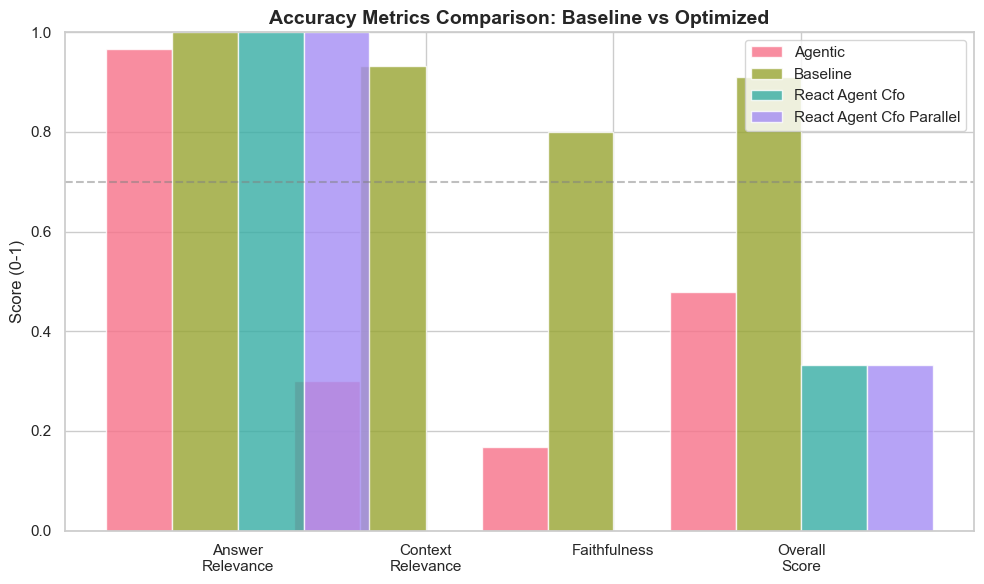

✓ Saved: accuracy_comparison.png


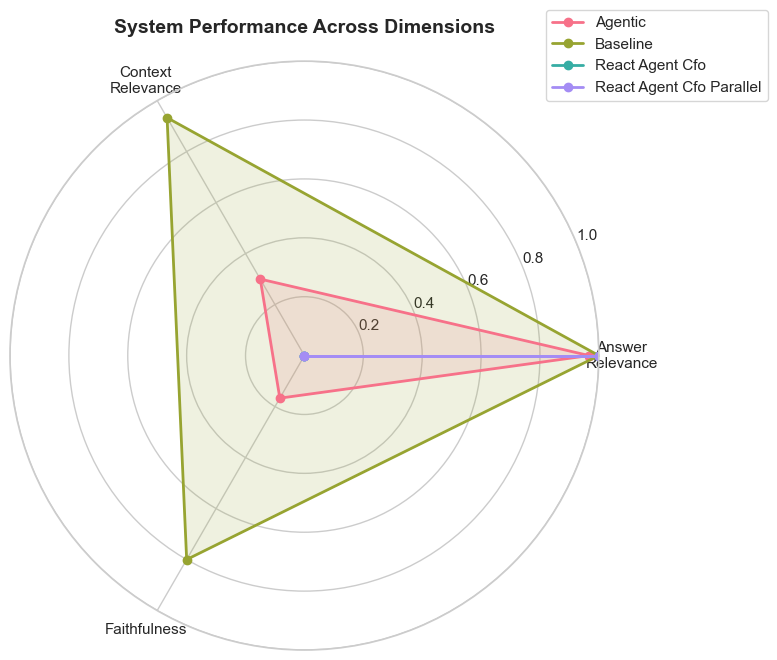

✓ Saved: accuracy_radar.png


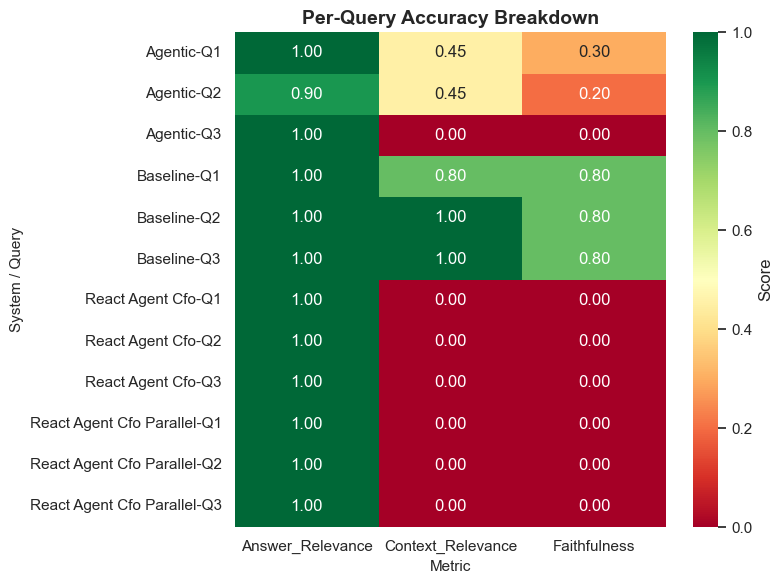

✓ Saved: accuracy_heatmap.png


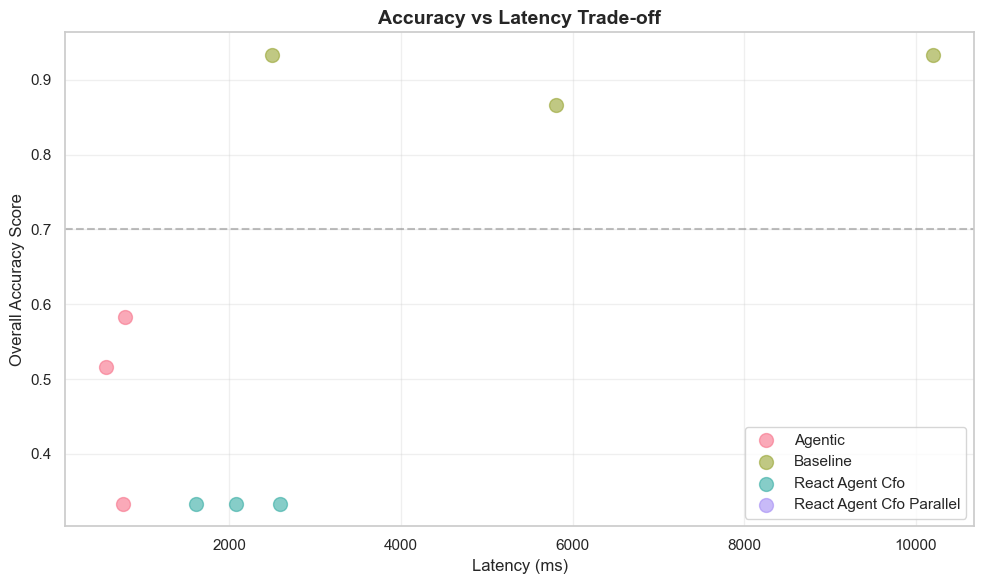

✓ Saved: accuracy_vs_latency.png

🔍 KEY INSIGHTS

• Agentic:
  Overall Score: 0.478
  Strongest: Answer Relevance (0.967)
  Needs Improvement: Faithfulness (0.167)

• Baseline:
  Overall Score: 0.911
  Strongest: Answer Relevance (1.000)
  Needs Improvement: Faithfulness (0.800)

• React Agent Cfo:
  Overall Score: 0.333
  Strongest: Answer Relevance (1.000)
  Needs Improvement: Context Relevance (0.000)

• React Agent Cfo Parallel:
  Overall Score: 0.333
  Strongest: Answer Relevance (1.000)
  Needs Improvement: Context Relevance (0.000)

✓ All files saved to: results/


In [ ]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Dict, List, Any
import re

# Setup
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100
RESULTS_DIR = Path("results")
RESULTS_DIR.mkdir(exist_ok=True, parents=True)

# ============================================================================
# EVALUATOR CLASSES
# ============================================================================

class AccuracyEvaluator:
    """Evaluates answer quality across multiple dimensions"""
    
    @staticmethod
    def evaluate_answer_relevance(query: str, answer: str) -> Dict[str, Any]:
        """Evaluate how well the answer addresses the query"""
        score = 0.0
        reasons = []
        
        query_lower = query.lower()
        answer_lower = answer.lower()
        
        # Check for metric presence
        metrics = ['margin', 'nim', 'expenses', 'opex', 'income', 'ratio', 'efficiency']
        metric_matches = sum(1 for m in metrics if m in query_lower and m in answer_lower)
        if metric_matches > 0:
            score += 0.3
            reasons.append(f"Contains {metric_matches} relevant metrics")
        
        # Check for time period references
        time_patterns = [r'\d{4}', r'\dQ\d{2}', r'quarter', r'year', r'fiscal']
        time_matches = sum(1 for p in time_patterns if re.search(p, query_lower) and re.search(p, answer_lower))
        if time_matches > 0:
            score += 0.3
            reasons.append(f"Addresses time period requirements")
        
        # Check for numerical data
        has_numbers = bool(re.search(r'\d+\.?\d*', answer))
        if has_numbers:
            score += 0.2
            reasons.append("Contains numerical data")
        
        # Check for table/structured format
        has_table = '|' in answer or 'table' in answer_lower
        if has_table:
            score += 0.1
            reasons.append("Provides structured data")
        
        # Check answer length
        word_count = len(answer.split())
        if 50 <= word_count <= 500:
            score += 0.1
            reasons.append(f"Appropriate length ({word_count} words)")
        
        return {
            'score': min(score, 1.0),
            'reasoning': '; '.join(reasons) if reasons else 'Generic answer'
        }
    
    @staticmethod
    def evaluate_context_relevance(query: str, citations: List) -> Dict[str, Any]:
        """Evaluate relevance of retrieved context"""
        if not citations:
            return {'score': 0.0, 'reasoning': 'No citations found'}
        
        score = 0.0
        reasons = []
        
        # Normalize citations to list of dicts (handle both string and dict formats)
        normalized_citations = []
        for c in citations:
            if isinstance(c, dict):
                normalized_citations.append(c)
            elif isinstance(c, str):
                # Extract filename from string citation (e.g., "file.pdf p.5")
                normalized_citations.append({'file': c, 'page': None})
            else:
                continue
        
        if not normalized_citations:
            return {'score': 0.0, 'reasoning': 'Invalid citation format'}
        
        # Citation count
        n_citations = len(normalized_citations)
        if n_citations >= 3:
            score += 0.3
            reasons.append(f"{n_citations} citations")
        elif n_citations >= 1:
            score += 0.15
            reasons.append(f"Limited citations ({n_citations})")
        
        # Source diversity
        unique_docs = len(set(c.get('file', '') for c in normalized_citations))
        if unique_docs >= 2:
            score += 0.2
            reasons.append(f"{unique_docs} different sources")
        elif unique_docs == 1:
            score += 0.1
            reasons.append("Single source")
        
        # Page number presence
        pages_cited = sum(1 for c in normalized_citations if c.get('page') is not None)
        if pages_cited > 0:
            score += 0.2
            reasons.append(f"{pages_cited}/{n_citations} have page numbers")
        
        # Document type relevance
        query_lower = query.lower()
        relevant_doc_types = []
        if 'quarter' in query_lower or any(f'{i}q' in query_lower for i in range(1,5)):
            relevant_doc_types.extend(['cfo_presentation', 'quarterly'])
        if 'year' in query_lower or 'fiscal' in query_lower:
            relevant_doc_types.extend(['annual_report', 'annual'])
        
        if relevant_doc_types:
            relevant_count = sum(1 for c in normalized_citations 
                                if any(dt in str(c.get('file', '')).lower() 
                                      for dt in relevant_doc_types))
            if relevant_count > 0:
                score += 0.2
                reasons.append(f"{relevant_count} relevant document types")
        else:
            score += 0.1
        
        # Recency check
        years = []
        for c in normalized_citations:
            file_str = str(c.get('file', ''))
            year_match = re.search(r'20(\d{2})', file_str)
            if year_match:
                years.append(int('20' + year_match.group(1)))
        
        if years and max(years) >= 2024:
            score += 0.1
            reasons.append(f"Recent sources (latest: {max(years)})")
        
        return {
            'score': min(score, 1.0),
            'reasoning': '; '.join(reasons)
        }
    
    @staticmethod
    def evaluate_faithfulness(answer: str, citations: List) -> Dict[str, Any]:
        """Evaluate whether answer is grounded in citations"""
        if not citations:
            return {'score': 0.0, 'reasoning': 'No citations to verify against'}
        
        score = 0.0
        reasons = []
        
        # Normalize citations (handle both string and dict formats)
        normalized_citations = []
        for c in citations:
            if isinstance(c, dict):
                normalized_citations.append(c)
            elif isinstance(c, str):
                normalized_citations.append({'file': c, 'page': None})
        
        if not normalized_citations:
            normalized_citations = [{'file': 'unknown', 'page': None}] * len(citations)
        
        # Check for citation markers
        citation_markers = ['[', 'source:', 'according to', 'p.', 'page']
        has_citations = any(marker in answer.lower() for marker in citation_markers)
        if has_citations:
            score += 0.4
            reasons.append("Contains citation markers")
        
        # Check quotes
        has_quotes = '"' in answer
        if has_quotes:
            if has_citations:
                score += 0.1
                reasons.append("Quoted material with citations")
            else:
                score -= 0.2
                reasons.append("WARNING: Quotes without citations")
        
        # Hedging language
        hedge_words = ['approximately', 'around', 'about', 'roughly', 'estimated']
        hedge_count = sum(1 for hw in hedge_words if hw in answer.lower())
        if hedge_count > 0:
            score += 0.1
            reasons.append("Uses appropriate hedging")
        
        # Admits limitations
        hallucination_flags = [
            'cannot find', 'not mentioned', 'not specified', 
            'data not available', 'context does not'
        ]
        admits_limitation = any(flag in answer.lower() for flag in hallucination_flags)
        if admits_limitation:
            score += 0.2
            reasons.append("Acknowledges data limitations")
        
        # Citation density
        word_count = len(answer.split())
        citation_count = len(normalized_citations)
        if word_count > 0:
            citation_density = citation_count / (word_count / 100)
            if citation_density >= 1.0:
                score += 0.2
                reasons.append(f"Good citation density ({citation_density:.1f}/100 words)")
            elif citation_density >= 0.5:
                score += 0.1
                reasons.append("Adequate citation density")
        
        return {
            'score': min(max(score, 0.0), 1.0),
            'reasoning': '; '.join(reasons) if reasons else 'Basic answer'
        }

# ============================================================================
# EVALUATION RUNNER
# ============================================================================

def evaluate_benchmark_results(results_dir: Path = Path("data_marker")) -> pd.DataFrame:
    """Evaluate all benchmark results"""
    json_files = list(results_dir.glob("bench_*.json"))
    
    if not json_files:
        print(f"⚠️  No benchmark files found in {results_dir}")
        return pd.DataFrame()
    
    all_rows = []
    evaluator = AccuracyEvaluator()
    
    for json_path in json_files:
        try:
            with open(json_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
        except Exception as e:
            print(f"Error loading {json_path}: {e}")
            continue
        
        system_name = json_path.stem.replace('bench_', '').replace('_', ' ').title()
        results = data.get('results', [])
        
        for i, result in enumerate(results, 1):
            query = result.get('query', '')
            answer = result.get('answer', '')
            citations = result.get('citations', [])
            
            # Evaluate
            answer_rel = evaluator.evaluate_answer_relevance(query, answer)
            context_rel = evaluator.evaluate_context_relevance(query, citations)
            faithful = evaluator.evaluate_faithfulness(answer, citations)
            
            all_rows.append({
                'System': system_name,
                'Query_ID': f'Q{i}',
                'Query': query[:60] + '...' if len(query) > 60 else query,
                'Answer_Relevance': answer_rel['score'],
                'Answer_Relevance_Reason': answer_rel['reasoning'],
                'Context_Relevance': context_rel['score'],
                'Context_Relevance_Reason': context_rel['reasoning'],
                'Faithfulness': faithful['score'],
                'Faithfulness_Reason': faithful['reasoning'],
                'Overall_Score': np.mean([
                    answer_rel['score'], 
                    context_rel['score'], 
                    faithful['score']
                ]),
                'Latency_ms': result.get('latency_ms'),
                'N_Citations': len(citations)
            })
    
    return pd.DataFrame(all_rows)

# ============================================================================
# PLOTTING FUNCTIONS
# ============================================================================

def plot_accuracy_comparison(summary_df, save_path):
    """Bar chart comparing accuracy metrics"""
    fig, ax = plt.subplots(figsize=(10, 6))
    
    metrics = ['Answer_Relevance', 'Context_Relevance', 'Faithfulness', 'Overall_Score']
    x = np.arange(len(metrics))
    width = 0.35
    
    systems = summary_df.index.tolist()
    colors = sns.color_palette("husl", len(systems))
    
    for i, system in enumerate(systems):
        values = [summary_df.loc[system, m] for m in metrics]
        offset = width * (i - len(systems)/2 + 0.5)
        ax.bar(x + offset, values, width, label=system, color=colors[i], alpha=0.8)
    
    ax.set_ylabel('Score (0-1)', fontsize=12)
    ax.set_title('Accuracy Metrics Comparison: Baseline vs Optimized', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(['Answer\nRelevance', 'Context\nRelevance', 'Faithfulness', 'Overall\nScore'])
    ax.legend()
    ax.set_ylim(0, 1.0)
    ax.axhline(y=0.7, color='gray', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

def plot_radar_chart(summary_df, save_path):
    """Radar chart for multi-dimensional comparison"""
    from math import pi
    
    metrics = ['Answer_Relevance', 'Context_Relevance', 'Faithfulness']
    systems = summary_df.index.tolist()
    
    angles = [n / float(len(metrics)) * 2 * pi for n in range(len(metrics))]
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))
    colors = sns.color_palette("husl", len(systems))
    
    for i, system in enumerate(systems):
        values = [summary_df.loc[system, m] for m in metrics]
        values += values[:1]
        ax.plot(angles, values, 'o-', linewidth=2, label=system, color=colors[i])
        ax.fill(angles, values, alpha=0.15, color=colors[i])
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(['Answer\nRelevance', 'Context\nRelevance', 'Faithfulness'], size=11)
    ax.set_ylim(0, 1)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.grid(True)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    ax.set_title('System Performance Across Dimensions', size=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

def plot_heatmap(accuracy_df, save_path):
    """Heatmap of per-query breakdown"""
    heatmap_data = accuracy_df.pivot_table(
        index=['System', 'Query_ID'],
        values=['Answer_Relevance', 'Context_Relevance', 'Faithfulness'],
        aggfunc='first'
    )
    
    fig, ax = plt.subplots(figsize=(8, max(6, len(heatmap_data) * 0.4)))
    sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='RdYlGn', 
                vmin=0, vmax=1, cbar_kws={'label': 'Score'}, ax=ax)
    ax.set_title('Per-Query Accuracy Breakdown', fontsize=14, fontweight='bold')
    ax.set_xlabel('Metric', fontsize=11)
    ax.set_ylabel('System / Query', fontsize=11)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

def plot_accuracy_vs_latency(accuracy_df, save_path):
    """Scatter plot of accuracy vs latency trade-off"""
    fig, ax = plt.subplots(figsize=(10, 6))
    
    systems = accuracy_df['System'].unique()
    colors = sns.color_palette("husl", len(systems))
    
    for i, system in enumerate(systems):
        system_data = accuracy_df[accuracy_df['System'] == system]
        ax.scatter(
            system_data['Latency_ms'],
            system_data['Overall_Score'],
            label=system,
            alpha=0.6,
            s=100,
            color=colors[i]
        )
    
    ax.set_xlabel('Latency (ms)', fontsize=12)
    ax.set_ylabel('Overall Accuracy Score', fontsize=12)
    ax.set_title('Accuracy vs Latency Trade-off', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0.7, color='gray', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

# ============================================================================
# MAIN EXECUTION
# ============================================================================

print("="*80)
print("📊 ACCURACY EVALUATION & VISUALIZATION")
print("="*80 + "\n")

# Step 1: Evaluate
print("Step 1: Running evaluation...\n")
accuracy_df = evaluate_benchmark_results(Path("data_marker"))

if accuracy_df.empty:
    print("❌ No benchmark results found!")
    print("Make sure you've run the benchmark runner first.")
else:
    # Save detailed results
    accuracy_df.to_csv(RESULTS_DIR / "accuracy_detailed.csv", index=False)
    print(f"✓ Detailed results saved: {RESULTS_DIR / 'accuracy_detailed.csv'}\n")
    
    # Generate summary
    summary_df = accuracy_df.groupby('System').agg({
        'Answer_Relevance': 'mean',
        'Context_Relevance': 'mean',
        'Faithfulness': 'mean',
        'Overall_Score': 'mean',
        'Latency_ms': ['median', lambda x: x.quantile(0.95)],
        'N_Citations': 'mean'
    }).round(3)
    
    summary_df.columns = [
        'Answer_Relevance', 'Context_Relevance', 'Faithfulness', 
        'Overall_Score', 'Latency_P50', 'Latency_P95', 'Avg_Citations'
    ]
    
    summary_df.to_csv(RESULTS_DIR / "accuracy_summary.csv")
    print(f"✓ Summary saved: {RESULTS_DIR / 'accuracy_summary.csv'}\n")
    
    # Print summary table
    print("\n" + "="*80)
    print("ACCURACY EVALUATION SUMMARY")
    print("="*80)
    print(summary_df.to_string())
    print("\n" + "="*80 + "\n")
    
    # Step 2: Generate visualizations
    print("Step 2: Generating visualizations...\n")
    
    plot_accuracy_comparison(summary_df, RESULTS_DIR / "accuracy_comparison.png")
    print(f"✓ Saved: accuracy_comparison.png")
    
    plot_radar_chart(summary_df, RESULTS_DIR / "accuracy_radar.png")
    print(f"✓ Saved: accuracy_radar.png")
    
    plot_heatmap(accuracy_df, RESULTS_DIR / "accuracy_heatmap.png")
    print(f"✓ Saved: accuracy_heatmap.png")
    
    plot_accuracy_vs_latency(accuracy_df, RESULTS_DIR / "accuracy_vs_latency.png")
    print(f"✓ Saved: accuracy_vs_latency.png")
    
    # Step 3: Key insights
    print("\n" + "="*80)
    print("🔍 KEY INSIGHTS")
    print("="*80 + "\n")
    
    for system in summary_df.index:
        overall = summary_df.loc[system, 'Overall_Score']
        answer_rel = summary_df.loc[system, 'Answer_Relevance']
        context_rel = summary_df.loc[system, 'Context_Relevance']
        faithful = summary_df.loc[system, 'Faithfulness']
        
        dims = [
            ('Answer Relevance', answer_rel),
            ('Context Relevance', context_rel),
            ('Faithfulness', faithful)
        ]
        
        print(f"• {system}:")
        print(f"  Overall Score: {overall:.3f}")
        print(f"  Strongest: {max(dims, key=lambda x: x[1])[0]} ({max(dims, key=lambda x: x[1])[1]:.3f})")
        print(f"  Needs Improvement: {min(dims, key=lambda x: x[1])[0]} ({min(dims, key=lambda x: x[1])[1]:.3f})")
        print()
    
    print("="*80)
    print(f"✓ All files saved to: {RESULTS_DIR}/")
    print("="*80)